In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
# %env CUDA_VISIBLE_DEVICES=4
%env DWAVE_API_TOKEN=DEV-1ba72787de429d2af12464f7753c10b9ff6945ad
!nvidia-smi
%config InlineBackend.figure_format = 'retina'

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: DWAVE_API_TOKEN=DEV-1ba72787de429d2af12464f7753c10b9ff6945ad
Tue Jul 16 19:17:04 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               Off |   00000000:1B:00.0 Off |                  Off |
| 30%   51C    P2            102W /  300W |    9483MiB /  49140MiB |     28%      Default |
|                                       

In [2]:
import hydra
from hydra.utils import instantiate
from hydra import initialize, compose

In [3]:
import sys
import os
import getpass

os.chdir('/home/' + getpass.getuser() + '/CaloQVAE/')
sys.path.insert(1, '/home/' + getpass.getuser() + '/CaloQVAE/')

In [4]:
#external libraries
import os
import pickle
import datetime
import sys
import yaml
import json

import torch.optim as optim
import torch
from torch import nn
from torch.nn.functional import binary_cross_entropy_with_logits
torch.manual_seed(32)
import numpy as np
np.random.seed(32)
import matplotlib.pyplot as plt
import hydra
from hydra.utils import instantiate

from omegaconf import OmegaConf

import time

# PyTorch imports
from torch import device, load, save
from torch.nn import DataParallel
from torch.cuda import is_available

# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
    
# Weights and Biases
import wandb

#self defined imports
from CaloQVAE import logging

[19:17:08.576] INFO   CaloQVAE                                          Willkommen!
[19:17:08.578] INFO   CaloQVAE                                          Loading configuration.


In [5]:
logger = logging.getLogger(__name__)

from data.dataManager import DataManager
from utils.plotting.plotProvider import PlotProvider
from engine.engine import Engine
from models.modelCreator import ModelCreator

from utils.plotting.HighLevelFeatures import HighLevelFeatures as HLF
# HLF_1_photons = HLF('photon', filename='/raid/javier/Datasets/CaloVAE/data/atlas/binning_dataset_1_photons.xml', wandb=False)
# HLF_1_pions = HLF('pion', filename='/raid/javier/Datasets/CaloVAE/data/atlas/binning_dataset_1_pions.xml', wandb=False)
# HLF_1_electron = HLF('electron', filename='/raid/javier/Datasets/CaloVAE/data/atlas_dataset2and3/binning_dataset_2.xml', wandb=False)

[19:17:11.117] INFO   numexpr.utils                                     Note: detected 96 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
[19:17:11.119] INFO   numexpr.utils                                     Note: NumExpr detected 96 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[19:17:11.120] INFO   numexpr.utils                                     NumExpr defaulting to 8 threads.
2024-07-16 19:17:11,891 dwave.cloud INFO  MainThread Log level for 'dwave.cloud' namespace set to 0
[19:17:11.891] INFO   dwave.cloud                                       Log level for 'dwave.cloud' namespace set to 0


In [6]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="configs")

hydra.initialize()

In [7]:

# config=compose(config_name="config.yaml")
config=compose(config_name="config.yaml")

HLF_1_photons = HLF('photon', filename=config.data.binning_xml_photons, wandb=False)
HLF_1_pions = HLF('pion', filename=config.data.binning_xml_pions, wandb=False)
HLF_1_electron = HLF('electron', filename=config.data.binning_xml_electrons, wandb=False)

wandb.init(project="caloqvae", entity=config.data.entity, config=config, mode='disabled')
modelCreator = ModelCreator(cfg=config)
dataMgr = DataManager(cfg=config)
#initialise data loaders
dataMgr.init_dataLoaders()
#run pre processing: get/set input dimensions and mean of train dataset
dataMgr.pre_processing()

if config.model.activation_fct.lower()=="relu":
    modelCreator.default_activation_fct=torch.nn.ReLU()
elif config.model.activation_fct.lower()=="tanh":
    modelCreator.default_activation_fct=torch.nn.Tanh()
else:
    logger.warning("Setting identity as default activation fct")
    modelCreator.default_activation_fct=torch.nn.Identity()

#instantiate the chosen model
#loads from file 
model=modelCreator.init_model(dataMgr=dataMgr)

#create the NN infrastructure
model.create_networks()

/usr/local/lib/python3.10/dist-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
[19:17:14.628] INFO   data.dataManager                                  Loading Data
[19:17:40.195] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f4b41fc7be0>: 80000 events, 625 batches
[19:17:40.200] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f4a83819e70>: 10000 events, 10 batches
[19:17:40.201] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f4b408e0820>: 10000 events, 10 batches
[19:17:42.805] INFO   models.modelCreator                               Initialising Model Type AtlasConditionalQVAEv2
2024-07-16 19:17:42,819 dwav

Initializing NetworkV3


In [8]:
#Not printing much useful info at the moment to avoid clutter. TODO optimise
model.print_model_info()
# for name, param in model.named_parameters():
#         print(name, param.requires_grad)

# Load the model on the GPU if applicable
# dev = None
# if (config.device == 'gpu') and config.gpu_list:
#     logger.info('Requesting GPUs. GPU list :' + str(config.gpu_list))
#     devids = ["cuda:{0}".format(x) for x in list(config.gpu_list)]
#     logger.info("Main GPU : " + devids[0])

#     if is_available():
#         print(devids[0])
#         dev = device(devids[0])
#         if len(devids) > 1:
#             logger.info(f"Using DataParallel on {devids}")
#             model = DataParallel(model, device_ids=list(config.gpu_list))
#         logger.info("CUDA available")
#     else:
#         dev = device('cpu')
#         logger.info("CUDA unavailable")
# else:
#     logger.info('Requested CPU or unable to use GPU. Setting CPU as device.')
#     dev = device('cpu')
# dev = torch.device("cuda:0")
dev = "cuda:{0}".format(config.gpu_list[0])

# Send the model to the selected device
# model.to(dev)
# Log metrics with wandb
wandb.watch(model)

# For some reason, need to use postional parameter cfg instead of named parameter
# with updated Hydra - used to work with named param but now is cfg=None 
engine=instantiate(config.engine, config)

#TODO for some reason hydra double instantiates the engine in a
#newer version if cfg=config is passed as an argument. This is a workaround.
#Find out why that is...
engine._config=config
#add dataMgr instance to engine namespace
engine.data_mgr=dataMgr
#add device instance to engine namespace
engine.device=dev    
#instantiate and register optimisation algorithm
engine.optimiser = torch.optim.Adam(model.parameters(),
                                    lr=config.engine.learning_rate)
#add the model instance to the engine namespace
engine.model = model
# add the modelCreator instance to engine namespace
engine.model_creator = modelCreator
engine.model = engine.model.to(dev)

[19:17:46.867] INFO   wandb                                             Watching
/home/luian1/.local/lib/python3.10/site-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)
[19:17:47.989] INFO   engine.engineAtlas                                Setting up engine Atlas.
[19:17:47.989] INFO   engine.engineCaloV3                               Setting up engine Calo.
[19:17:47.990] INFO   engine.engine                                     Setting up default engine.


In [9]:
# config=compose(config_name="config.yaml")
config_2=compose(config_name="config.yaml")
wandb.init(project="caloqvae", entity="qvae", config=config_2, mode='disabled')
modelCreator_2 = ModelCreator(cfg=config_2)
dataMgr_2 = DataManager(cfg=config_2)
#initialise data loaders
dataMgr_2.init_dataLoaders()
#run pre processing: get/set input dimensions and mean of train dataset
dataMgr_2.pre_processing()

if config_2.model.activation_fct.lower()=="relu":
    modelCreator_2.default_activation_fct=torch.nn.ReLU()
elif config_2.model.activation_fct.lower()=="tanh":
    modelCreator_2.default_activation_fct=torch.nn.Tanh()
else:
    logger.warning("Setting identity as default activation fct")
    modelCreator_2.default_activation_fct=torch.nn.Identity()

#instantiate the chosen model
#loads from file 
model_2=modelCreator_2.init_model(dataMgr=dataMgr_2)

#create the NN infrastructure
model_2.create_networks()

engine_2=instantiate(config_2.engine, config_2)

#TODO for some reason hydra double instantiates the engine in a
#newer version if cfg=config is passed as an argument. This is a workaround.
#Find out why that is...
engine_2._config=config_2
#add dataMgr instance to engine namespace
engine_2.data_mgr=dataMgr_2
#add device instance to engine namespace
engine_2.device=dev    
#instantiate and register optimisation algorithm
engine_2.optimiser = torch.optim.Adam(model_2.parameters(),
                                    lr=config_2.engine.learning_rate)
#add the model instance to the engine namespace
engine_2.model = model_2
# add the modelCreator instance to engine namespace
engine_2.model_creator = modelCreator_2
engine_2.model = engine_2.model.to(dev)

/usr/local/lib/python3.10/dist-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
[19:17:48.601] INFO   data.dataManager                                  Loading Data
[19:18:16.865] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f4a0e803f10>: 80000 events, 625 batches
[19:18:16.867] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f4a0e803f40>: 10000 events, 10 batches
[19:18:16.868] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f4a0e803eb0>: 10000 events, 10 batches
[19:18:20.309] INFO   models.modelCreator                               Initialising Model Type AtlasConditionalQVAEv2
2024-07-16 19:18:20,319 dwav

Initializing NetworkV3


[19:18:24.159] INFO   engine.engineAtlas                                Setting up engine Atlas.
[19:18:24.160] INFO   engine.engineCaloV3                               Setting up engine Calo.
[19:18:24.161] INFO   engine.engine                                     Setting up default engine.


In [10]:
train_loader,test_loader,val_loader = engine.data_mgr.create_dataLoader()

[19:18:52.308] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f4cd4ef1ed0>: 80000 events, 625 batches
[19:18:52.311] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f4cd4ef2c20>: 10000 events, 10 batches
[19:18:52.312] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f4a375f3100>: 10000 events, 10 batches


In [11]:
###LOAD MODEL
# engine.model.prior._weight_dict['03']
# engine.model.prior.fullyconnected
# engine.model._config.model.fullyconnected


In [12]:
engine.model._qpu_sampler.properties["chip_id"]

'Advantage2_prototype2.3'

In [13]:
# wordly-fog-352 | CNN + cond + scaled data + \pow(1+x, 1/4) BCE + Cyl encoderDec
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-04-04/19-10-12/wandb/run-20240404_191013-a690v1bu/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
# modelname = 'world-fog-352'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-04-04/19-10-12/wandb/run-20240404_191013-a690v1bu/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True    
    
    
# # # emissary-think-tank-353 | CNN + cond + scaled data + Cyl EncDec
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-04-05/12-01-16/wandb/run-20240405_120117-67fx57x8/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# # modelname = 'emissary-think-tank-353'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2024-04-05/12-01-16/wandb/run-20240405_120117-67fx57x8/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=True  
    
    

    
# # nothern-microwave-356 | CNN + cond + scaled data + Cyl EncDec
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-04-08/17-47-59/wandb/run-20240408_174800-83zkah0g/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# modelname = 'nothern-microwave-356'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-04-08/17-47-59/wandb/run-20240408_174800-83zkah0g/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True 
    
    
# # # dark-sky-357 | CNN + cond + scaled data + Cyl EncDec
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-04-08/18-22-13/wandb/run-20240408_182214-ftos7bwv/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# # modelname = 'dark-sky-357'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2024-04-08/18-22-13/wandb/run-20240408_182214-ftos7bwv/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=True 


# # # rural-cosmos-358 | CNN + cond + scaled data + Cyl EncDec
# # # run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-04-10/21-09-25/wandb/run-20240410_210926-1fmsh565/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-04-10/21-09-25/wandb/run-20240415_105702-1fmsh565/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# # modelname = 'rural-cosmos-358'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2024-04-10/21-09-25/wandb/run-20240415_105702-1fmsh565/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=True 
    
    
# # # rare-lake-359 | CNN + cond + scaled data + Cyl EncDec + logits passed on encoder
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-04-15/17-11-53/wandb/run-20240415_171154-1p5wt0sy/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# # modelname = 'rare-lake-359'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2024-04-15/17-11-53/wandb/run-20240415_171154-1p5wt0sy/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=True 
    
    
# # deft-meadow-360 | CNN + cond + scaled data + Cyl EncDec + logits passed on encoder + no BCE weight
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-04-17/13-20-06/wandb/run-20240417_132007-grs8jl3h/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# modelname = 'deft-meadow-360'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-04-17/13-20-06/wandb/run-20240417_132007-grs8jl3h/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True 
    
    
# # dazzling-cloud-361 | CNN + cond + scaled data + Cyl EncDec + no BCE weight + clamped logits at 10
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-04-18/14-02-08/wandb/run-20240418_140209-mjj5yuvx/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# modelname = 'dazzling-cloud-361'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-04-18/14-02-08/wandb/run-20240418_140209-mjj5yuvx/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True 
    
    
# # fast-bee-363 | CNN + cond + scaled data + Cyl EncDec +Fully connected RBM
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-04-19/19-12-27/wandb/run-20240419_191228-1wkunmev/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
# modelname = 'fast-bee-363'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-04-19/19-12-27/wandb/run-20240419_191228-1wkunmev/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True 


# # deep-snowball-367 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log energy encoded
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-04-22/19-21-15/wandb/run-20240422_192116-p4gannm2/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# modelname = 'deep-snowball-367'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-04-22/19-21-15/wandb/run-20240422_192116-p4gannm2/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True  
    
    
# # # soft-violet-374 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log energy encoded + Zephyr
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-04-24/15-23-11/wandb/run-20240424_152312-wn4msoz2/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# # modelname = 'soft-violet-374'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2024-04-24/15-23-11/wandb/run-20240424_152312-wn4msoz2/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=True 
    
    
# # # dutiful-bird-375 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log energy encoded + CRBM
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-04-24/20-12-01/wandb/run-20240424_201202-so4nwdou/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
# # modelname = 'dutiful-bird-375'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2024-04-24/20-12-01/wandb/run-20240424_201202-so4nwdou/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=True 
    
    
# # # sunny-firebrand-376 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log energy encoded + Zephyr+ CRBM
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-04-25/13-08-39/wandb/run-20240425_130840-nmqieu71/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# # modelname = 'sunny-firebrand-376'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2024-04-25/13-08-39/wandb/run-20240425_130840-nmqieu71/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=True 
    

# # graceful-plasma-378 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log energy encoded + Zephyr+ CRBM
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-04-29/17-29-12/wandb/run-20240429_172912-uzp3fv73/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# modelname = 'graceful-plasma-378'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-04-29/17-29-12/wandb/run-20240429_172912-uzp3fv73/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True
    

# # # solar-wildflower-379 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log energy encoded + CRBM
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-04-30/13-53-54/wandb/run-20240430_135355-73aho6c2/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# # modelname = 'solar-wildflower-379'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2024-04-30/13-53-54/wandb/run-20240430_135355-73aho6c2/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=True


# # feasible-dust-380 | CNN + cond + scaled data + Cyl EncDec + lin energy encoded + CRBM
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-05-01/13-05-50/wandb/run-20240501_130551-4rr2g0s4/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
# modelname = 'feasible-dust-380'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-05-01/13-05-50/wandb/run-20240501_130551-4rr2g0s4/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True
    
    
# # # stilted-morning-381 | CNN + cond + scaled data + Cyl EncDec + lin energy encoded + CRBM + no freeze out
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-05-01/19-46-04/wandb/run-20240501_194605-4f6qr1dt/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
# # modelname = 'stilted-morning-381'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2024-05-01/19-46-04/wandb/run-20240501_194605-4f6qr1dt/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=True
    
    
# # fallen-disco-383 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-05-02/18-46-03/wandb/run-20240502_184604-opz17u3d/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# modelname = 'fallen-disco-383'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-05-02/18-46-03/wandb/run-20240502_184604-opz17u3d/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True
    
    
# # # breezy-smoke-389 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-05-06/21-43-41/wandb/run-20240506_214342-tyclqjw4/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# # modelname = 'breezy-smoke-389'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2024-05-06/21-43-41/wandb/run-20240506_214342-tyclqjw4/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=True
    

# # # logical-dragon-394 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-05-08/18-58-30/wandb/run-20240508_185831-yxmk5x30/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# # modelname = 'logical-dragon-394'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2024-05-08/18-58-30/wandb/run-20240508_185831-yxmk5x30/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=True

# # copper-vortex-404 is very similar to previous. Larger FCN at the end. Behaves very similar to previous model

# # northern-sunset-406 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-05-10/10-55-05/wandb/run-20240510_105506-8txbu380/files/AtlasConditionalQVAE_atlas_default_100.pth"
# modelname = 'northern-sunset-406'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-05-10/10-55-05/wandb/run-20240510_105506-8txbu380/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True
    
    
# # misunderstood-frost-410 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-05-12/16-24-06/wandb/run-20240512_162407-tz6u5opn/files/AtlasConditionalQVAE_atlas_default_120.pth"
# modelname = 'misunderstood-frost-410'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-05-12/16-24-06/wandb/run-20240512_162407-tz6u5opn/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True


# # # flowing-grass-411 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-05-13/13-18-33/wandb/run-20240513_131834-5saza00m/files/AtlasConditionalQVAE_atlas_default_best.pth"
# # modelname = 'flowing-grass-411'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2024-05-13/13-18-33/wandb/run-20240513_131834-5saza00m/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=True


# # dry-silence-412 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-05-15/14-28-01/wandb/run-20240515_142802-3la2tybf/files/AtlasConditionalQVAE_atlas_default_100.pth"
# modelname = 'dry-silence-412'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-05-15/14-28-01/wandb/run-20240515_142802-3la2tybf/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True
    
    
# # # young-wildflower-413 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-05-16/15-20-10/wandb/run-20240516_152011-cyeoc1or/files/AtlasConditionalQVAE_atlas_default_best.pth"
# # modelname = 'young-wildflower-412'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2024-05-16/15-20-10/wandb/run-20240516_152011-cyeoc1or/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=True
    
    
# # astral-terrain-415 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-05-16/19-47-55/wandb/run-20240516_194756-dt99yb97/files/AtlasConditionalQVAE_atlas_default_50.pth"
# modelname = 'astral-terrain-415'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-05-16/19-47-55/wandb/run-20240516_194756-dt99yb97/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True
    
    
# # morning-breeze-420 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-05-18/15-22-04/wandb/run-20240518_152205-pi1sujcx/files/AtlasConditionalQVAE_atlas_default_150.pth"
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-05-18/15-22-04/wandb/run-20240524_194939-pi1sujcx/files/AtlasConditionalQVAE_atlas_default_230.pth"
# modelname = 'morning-breeze-420'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-05-18/15-22-04/wandb/run-20240524_194939-pi1sujcx/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True
    
    
# # gallant-capybara-418 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2 + Z
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-05-18/15-20-30/wandb/run-20240518_152031-zhvzuxif/files/AtlasConditionalQVAE_atlas_default_150.pth"
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-05-18/15-20-30/wandb/run-20240524_194447-zhvzuxif/files/AtlasConditionalQVAE_atlas_default_250.pth"
# modelname = 'gallant-capybara-418'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-05-18/15-20-30/wandb/run-20240518_152031-zhvzuxif/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True
    
    
# # royal-plant-447 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2 +scaled
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-05-29/14-07-25/wandb/run-20240529_140726-f9sdv5v2/files/AtlasConditionalQVAE_atlas_default_10.pth"
# modelname = 'royal-plant-447'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-05-29/14-07-25/wandb/run-20240529_140726-f9sdv5v2/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False   
    
# # brisk-bird-447 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2 +scaled
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-05-30/11-00-37/wandb/run-20240530_110038-oyw5vuog/files/AtlasConditionalQVAE_atlas_default_20.pth"
# modelname = 'brisk-bird-447'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-05-30/11-00-37/wandb/run-20240530_110038-oyw5vuog/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False  
    
    
# # #toasty-pond-448 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2 +scaled
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-05-30/16-39-43/wandb/run-20240530_163944-g59w6j0e/files/AtlasConditionalQVAE_atlas_default_140.pth"
# # modelname = 'toasty-pond-448'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2024-05-30/16-39-43/wandb/run-20240530_163944-g59w6j0e/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=False
    
    
# # # solar-cloud-449 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2 +scaled
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-05-30/19-04-18/wandb/run-20240530_190419-42l10ppy/files/AtlasConditionalQVAE_atlas_default_20.pth"
# # modelname = 'solar-cloud-449'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2024-05-30/19-04-18/wandb/run-20240530_190419-42l10ppy/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=False 


# # twilight-river-450 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2 +scaled
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-05-31/19-11-05/wandb/run-20240531_191106-4dsnfwl4/files/GumBoltAtlasPRBMCNN_atlas_default_150.pth"
# modelname = 'twilight-river-450'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-05-31/19-11-05/wandb/run-20240531_191106-4dsnfwl4/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False 


# #helpful-star-450 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2 +scaled
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-06-03/00-59-55/wandb/run-20240603_005956-nwgtxcyj/files/AtlasConditionalQVAE_atlas_default_120.pth"
# modelname = 'helpful-star-450'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-06-03/00-59-55/wandb/run-20240603_005956-nwgtxcyj/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False
    
    
# #glowing-meadow-453 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2 +scaled
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-06-03/23-59-58/wandb/run-20240603_235959-1txgiuch/files/AtlasConditionalQVAE_atlas_default_100.pth"
# modelname = 'glowing-meadow-453'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-06-03/23-59-58/wandb/run-20240603_235959-1txgiuch/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False


# #honest-hill-454 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2 +scaled
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-06-04/19-27-16/wandb/run-20240604_192717-n57xkuzr/files/AtlasConditionalQVAE_atlas_default_150.pth"
# modelname = 'honest-hill-454'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-06-04/19-27-16/wandb/run-20240604_192717-n57xkuzr/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False
    
    
# #pretty-shape-455 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2 +scaled
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-06-05/03-07-35/wandb/run-20240605_030736-20kaac85/files/AtlasConditionalQVAE_atlas_default_150.pth"
# modelname = 'pretty-shape-455'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-06-05/03-07-35/wandb/run-20240605_030736-20kaac85/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False



# #wobbly-aardvark-456 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2 +scaled
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-06-06/12-49-34/wandb/run-20240606_124935-30h7h1uj/files/AtlasConditionalQVAE_atlas_default_100.pth"
# modelname = 'wobbly-aardvark-456'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-06-06/12-49-34/wandb/run-20240606_124935-30h7h1uj/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False

# run_path = "/fast_scratch_1/caloqvae/luian1/wandb/run-20240620_223442-7ggy3s19/files/AtlasConditionalQVAEv2_atlas_default_best.pth"
# # run_path = "/fast_scratch_1/caloqvae/luian1/wandb/run-20240620_223442-7ggy3s19/files/AtlasConditionalQVAEv2_atlas_default_150.pth"
# modelname = 'dutiful-silence-108'
# datascaled = 'reduced'
# with open("/fast_scratch_1/caloqvae/luian1/wandb/run-20240620_223442-7ggy3s19/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False

# jumping-wave-204 no Hierarchical Decoders - 3D Convolutions on 0.01 on Zephyr Topology
run_path = "/fast_scratch_1/caloqvae/luian1/wandb/run-20240713_101327-d3gqz2n9/files/AtlasConditionalQVAEv2_atlas_default_best.pth"

modelname = 'worthy-vortex-203'
datascaled = 'reduced'
with open("/fast_scratch_1/caloqvae/luian1/wandb/run-20240713_101327-d3gqz2n9/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=False

    
arch = config['model']['model_type']
part = config['data']['particle_type']
print(arch)
print(part)
print(scaled, reducedata)


# load_state(model, run_path, 'cuda:{0}'.format(cfg.gpu_list[0]))
# load_state(model, run_path, dev)
modelCreator.load_state(run_path, dev)
engine.model.eval();

[19:18:52.400] INFO   models.modelCreator                               Loading state


AtlasConditionalQVAEv2
electron-ds2
False True


[19:18:52.616] INFO   models.modelCreator                               Loading weights from file : /fast_scratch_1/caloqvae/luian1/wandb/run-20240713_101327-d3gqz2n9/files/AtlasConditionalQVAEv2_atlas_default_best.pth


Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder


In [14]:
lnZais = engine.model.stater.AIS(30).detach().cpu().item()

In [15]:
lnZrais = engine.model.stater.RAIS(20).detach().cpu().item()
print(lnZais, lnZrais)

2740.80322265625 2740.698486328125


In [16]:
lnZais_rdm = engine_2.model.stater.AIS(30).detach().cpu().item()
lnZrais_rdm = engine_2.model.stater.RAIS(20).detach().cpu().item()
print(lnZais_rdm, lnZrais_rdm)

1586.5263671875 1587.450927734375


In [17]:
# engine.model.prior.bias_dict     # weight_dict['01']
engine.model.prior.weight_dict.items()

<generator object ParameterDict.items.<locals>.<genexpr> at 0x7f4a25d87060>

In [18]:
import h5py
with h5py.File("/home/javier/RBM_weights.hdf5", 'w') as hdf_file:
    for key, value in engine.model.prior.weight_dict.items():
        # Each key-value pair in the dictionary becomes a dataset in the HDF5 file
        hdf_file.create_dataset(key, data=value.detach().cpu())
        
with h5py.File("/home/javier/RBM_biases.hdf5", 'w') as hdf_file:
    for key, value in engine.model.prior.bias_dict.items():
        # Each key-value pair in the dictionary becomes a dataset in the HDF5 file
        hdf_file.create_dataset(key, data=value.detach().cpu())

FileNotFoundError: [Errno 2] Unable to synchronously create file (unable to open file: name = '/home/javier/RBM_weights.hdf5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

In [19]:
hfont = {'fontname':'Helvetica'}
ds = {'electron-ds2':'Dataset 2', 'pion1':'Dataset 1: π'}

In [20]:
xx = next(iter(test_loader))
in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1]) # input , label

torch.Size([1024, 6480])


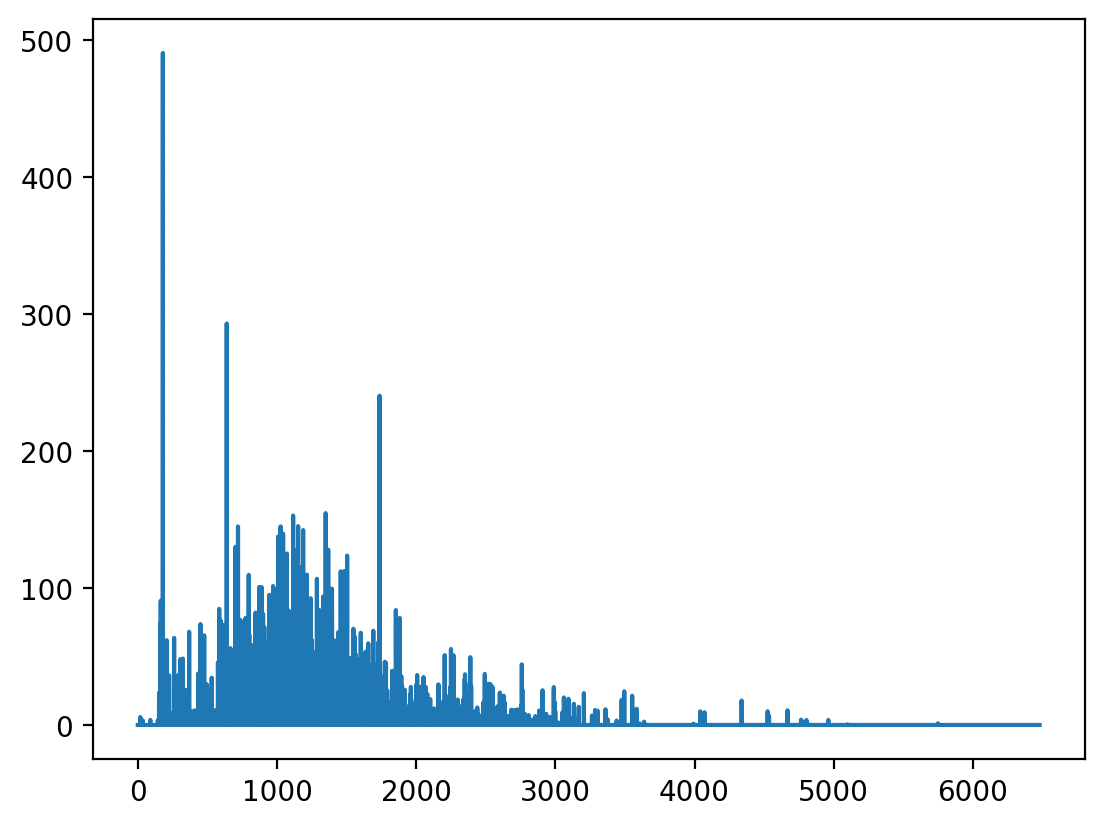

In [21]:
print(in_data.shape)
plt.plot(in_data.cpu().numpy()[3,:])

In [22]:
with torch.no_grad():
    in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
    if True: #reducedata:
        in_data = engine._reduce(in_data, true_energy)
    fwd_output = engine.model((in_data, true_energy), True)
    engine._model.sampler._batch_size = true_energy.shape[0]
    sample_energies, sample_data = engine._model.generate_samples_cond(num_samples=true_energy.shape[0], true_energy=true_energy)
    # sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
idx = 0
plt.plot(in_data.cpu().numpy()[idx,:])
plt.plot(fwd_output.output_activations.detach().cpu().numpy()[idx,:], alpha=0.5)
plt.plot(sample_data.detach().cpu().numpy()[idx,:], alpha=0.5)
plt.legend(["gt","recon","samp"])
plt.xlabel("voxel index")
plt.ylabel("energy per voxel in new variable")
plt.show()

plt.plot(engine._reduceinv(in_data,true_energy).cpu().numpy()[idx,:])
plt.plot(engine._reduceinv(fwd_output.output_activations,true_energy).detach().cpu().numpy()[idx,:], alpha=0.5)
plt.plot(engine._reduceinv(sample_data, true_energy).detach().cpu().numpy()[idx,:], alpha=0.5)
plt.legend(["gt","recon","samp"])
plt.xlabel("voxel index")
plt.ylabel("energy per voxel")
plt.show()

plt.plot(engine._reduceinv(in_data,true_energy).cpu().numpy()[idx,:]/true_energy.cpu().numpy()[idx,0])
plt.plot(engine._reduceinv(fwd_output.output_activations,true_energy).detach().cpu().numpy()[idx,:]/true_energy.cpu().numpy()[idx,0], alpha=0.5)
plt.plot(engine._reduceinv(sample_data, true_energy).detach().cpu().numpy()[idx,:]/true_energy.cpu().numpy()[idx,0], alpha=0.5)
plt.legend(["gt","recon","samp"])
plt.xlabel("voxel index")
plt.ylabel("energy per voxel")
plt.show()
print(true_energy[idx,:], engine._reduceinv(in_data, true_energy)[idx,:].sum())

RuntimeError: unflatten: Provided sizes [1208, 1, 1, 1] don't multiply up to the size of dim 1 (3020) in the input tensor

In [ ]:
directory_path = f'/home/luian1/CaloQVAE/figs/{modelname}'
if not os.path.isdir(directory_path):
    os.mkdir(directory_path) 
    print(modelname)
else:
    pass

In [ ]:
beta, beta_list, rbm_energy_list, dwave_energy_list, thrsh_met = engine.model.find_beta(num_reads=256, beta_init=4.41, lr=0.01, num_epochs = 30, delta = 4.0, method = 2, TOL=True, const = 1.0, adaptive = True)
beta0 = beta

In [ ]:
plt.scatter(range(len(beta_list)), beta_list, linewidth=2.5, color="b" )
plt.plot(range(len(beta_list)), beta_list, linewidth=1.5, color="b" )
plt.xlabel("Iterations", fontsize=15)
plt.ylabel("Estimated $β_{QA}$", fontsize=15)
plt.legend([f'Chip {engine.model._qpu_sampler.properties["chip_id"]}'], fontsize=15)
# plt.title(f'{ds[part]}')
plt.grid("True")
plt.savefig(f'/home/luian1/CaloQVAE/figs/{modelname}/beta_QA_{engine.model._qpu_sampler.properties["chip_id"]}_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [ ]:
QA = "$β_{QA}$"

In [ ]:
Hoffset = -(sum([engine.model.prior.bias_dict[key].sum().detach().cpu().item() for key in engine.model.prior.bias_dict.keys()])/2 
            + sum([engine.model.prior.weight_dict[key].sum().detach().cpu().item() for key in engine.model.prior.weight_dict.keys()])/4)


In [ ]:
plt.figure(figsize=(8,6))
plt.hist(rbm_energy_list[-1] + Hoffset, density=True, color="orange", alpha=0.7)
plt.hist(dwave_energy_list[-1] + Hoffset, density=True, color="m", alpha=0.7)
plt.xlabel("RBM Energy", fontsize=15)
plt.ylabel("PDF", fontsize=15)
plt.legend(["Classical samples", "QPU samples"], fontsize=17)
# plt.title(f'ln(Z)[AIS] = {np.round(Zais)}, ln(Z)[RAIS] = {np.round(Zrais)}')
plt.figtext(0.7, 0.6, f'Est. {QA} = {np.round(beta0, 2)}', ha='center', va='top', fontsize=17, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))
plt.subplots_adjust(bottom=0.2)
plt.grid("True")
plt.savefig(f'/home/luian1/CaloQVAE/figs/{modelname}/Ising_energy_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()
print(len(rbm_energy_list[-1]))
print(len(dwave_energy_list[-1]))

In [ ]:
partition_size=config.model.n_latent_nodes_per_p
energy_encoded_data = []

engine.model.eval()
with torch.no_grad():
    for xx in val_loader:
        in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
        if reducedata:
            in_data = engine._reduce(in_data, true_energy, R=R)
        # enIn = torch.cat((in_data, true_energy), dim=1)
        # beta, post_logits, post_samples = engine.model.encoder(enIn, False)
        beta, post_logits, post_samples = engine.model.encoder(in_data, true_energy, False)
        post_samples = torch.cat(post_samples, 1)
        post_samples_energy = engine.model.stater.energy_samples(post_samples[:,0:partition_size], post_samples[:,partition_size:2*partition_size], 
                                                 post_samples[:,2*partition_size:3*partition_size], post_samples[:,3*partition_size:4*partition_size], 1.0 )
        energy_encoded_data.append(post_samples_energy.detach().cpu())

energy_encoded_data = torch.cat(energy_encoded_data, dim=0)

In [ ]:
# engine.model.prior_samples[:,0:512], engine.model.prior_samples[:,512:1024], engine.model.prior_samples[:,1024:1536], engine.model.prior_samples[:,1536:2048]
energy_dwave = engine.model.stater.energy_samples(engine.model.prior_samples[1000:,0:512], engine.model.prior_samples[1000:,512:1024], 
                                                  engine.model.prior_samples[1000:,1024:1536], engine.model.prior_samples[1000:,1536:2048], 1.0)
# _energy_rbm = engine.model.stater.energy_samples(rbm_data[-250:,0:512], rbm_data[-250:,512:1024], rbm_data[-250:,1024:1536], rbm_data[-250:,1536:2048], 1.0)
# (rbm_data[-250:,0:512] == engine.model.prior_samples[:,0:512]).prod()
engine.model.prior_samples.shape
energy_dwave.shape

In [ ]:
(engine.model.prior_samples[1000:,:512] == rbm_data[:,:512]).prod()

In [ ]:
plt.hist(energy_dwave.detach().cpu()+ Hoffset/2, density=True)
plt.hist(energy_rbm_data.detach().cpu(), alpha=0.5, density=True)
print(rbm_data.shape, energy_rbm_data.detach().cpu().mean() - energy_dwave.detach().cpu().mean(),
     energy_rbm_data.shape, energy_dwave.shape)

In [ ]:

partition_size=config.model.n_latent_nodes_per_p
encoded_data = []
energy_encoded_data = []
n_samples4_qpu = 200

# encoded_data_rdm = []
# energy_encoded_data_rdm = []
engine.model.eval()
# engine_2.model.eval()
with torch.no_grad():
    for xx in val_loader:
    # for xx in train_loader:
        in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
        #################################################
        # true_energy = true_energy[:n_samples4_qpu,:]
        # in_data = in_data[:n_samples4_qpu,:]
        #################################################
        if reducedata:
            in_data = engine._reduce(in_data, true_energy, R=R)
        # enIn = torch.cat((in_data, true_energy), dim=1)
        # beta, post_logits, post_samples = engine.model.encoder(enIn, False)
        beta, post_logits, post_samples = engine.model.encoder(in_data, true_energy, False)
        post_samples = torch.cat(post_samples, 1)
        post_samples_energy = engine.model.stater.energy_samples(post_samples[:,0:partition_size], post_samples[:,partition_size:2*partition_size], 
                                                 post_samples[:,2*partition_size:3*partition_size], post_samples[:,3*partition_size:4*partition_size], 1.0 )
        encoded_data.append(post_samples.detach().cpu())
        energy_encoded_data.append(post_samples_energy.detach().cpu())
        
        # #Rdm model
        # # enIn = torch.cat((in_data, true_energy), dim=1)
        # # beta, post_logits, post_samples = engine.model.encoder(enIn, False)
        # beta, post_logits, post_samples = engine_2.model.encoder(in_data, true_energy, False)
        # post_samples = torch.cat(post_samples, 1)
        # post_samples_energy = engine_2.model.stater.energy_samples(post_samples[:,0:partition_size], post_samples[:,partition_size:2*partition_size], 
        #                                          post_samples[:,2*partition_size:3*partition_size], post_samples[:,3*partition_size:4*partition_size], 1.0 )
        # encoded_data_rdm.append(post_samples.detach().cpu())
        # energy_encoded_data_rdm.append(post_samples_energy.detach().cpu())

encoded_data = torch.cat(encoded_data, dim=0)
energy_encoded_data = torch.cat(energy_encoded_data, dim=0)
        
# encoded_data_rdm = torch.cat(encoded_data_rdm, dim=0)
# energy_encoded_data_rdm = torch.cat(energy_encoded_data_rdm, dim=0)

p1,p2,p3,p4 = post_samples[:,0:partition_size], post_samples[:,partition_size:2*partition_size], \
                                                 post_samples[:,2*partition_size:3*partition_size], post_samples[:,3*partition_size:4*partition_size]

energy_rbm_data = []
rbm_data = []
# energy_rbm_rdm_data = []
with torch.no_grad():
    # for i in range(10):
    for xx in val_loader:
        in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
        ##################################################
        # true_energy = true_energy[:n_samples4_qpu,:]
        # in_data = in_data[:n_samples4_qpu,:]
        ##################################################
        # if i == 0:
            # p1, p2, p3, p4 = engine.model.stater.block_gibbs_sampling_ais(1.0)
        # else:
            # p1, p2, p3, p4 = engine.model.stater.block_gibbs_sampling_ais(1.0, p1, p2, p3, p4)
        engine._model.sampler._batch_size = true_energy.shape[0]
        if True:
            u = engine.model.encoder.binary_energy(true_energy).to(dtype=torch.float32)
            p1, p2, p3, p4 = engine.model.sampler.block_gibbs_sampling_cond(u)
        else:
            p1, p2, p3, p4 = engine.model.sampler.block_gibbs_sampling()
        rbm_data.append(torch.cat((p1,p2,p3,p4),1))
        rbm_samples_energy = engine.model.stater.energy_samples(p1, p2, p3, p4, 1.0)
        energy_rbm_data.append(rbm_samples_energy.detach().cpu())
        engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
        
        # if i == 0:
        #     p1_r, p2_r, p3_r, p4_r = engine_2.model.stater.block_gibbs_sampling_ais(1.0)
        # else:
        #     p1_r, p2_r, p3_r, p4_r = engine_2.model.stater.block_gibbs_sampling_ais(1.0, p1_r, p2_r, p3_r, p4_r)
        # rbm_rdm_samples_energy = engine_2.model.stater.energy_samples(p1_r, p2_r, p3_r, p4_r, 1.0)
        # energy_rbm_rdm_data.append(rbm_rdm_samples_energy.detach().cpu())
    
energy_rbm_data = torch.cat(energy_rbm_data, dim=0)
rbm_data = torch.cat(rbm_data,0)
# energy_rbm_rdm_data = torch.cat(energy_rbm_rdm_data, dim=0)

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(energy_encoded_data.numpy(), bins=70, linewidth=2.5, color="b", density=True, log=True)
plt.hist(energy_rbm_data.numpy(), bins=20, color="orange", density=True, fc=(1, 0, 1, 0.5), histtype='step', linewidth=1.5)
plt.hist(energy_rbm_rdm_data.numpy(), bins=20, linewidth=2.5, color="cyan", density=True, fc=(0.5, 1.0, 0.5, 0.8))
plt.hist(energy_encoded_data_rdm.numpy(), bins=70, linewidth=2.5, color="r", density=True)

plt.xlabel("RBM Energy", fontsize=15)
plt.ylabel("PDF", fontsize=15)
plt.legend(["Trained RBM w/ Encoded Data", "Trained RBM w/ Gibbs sampled data", "Random RBM w/ Gibbs sampled data", "Random RBM w/ Init Encoded Data"], fontsize=17)
# plt.title(f'ln(Z)[AIS] = {np.round(Zais)}, ln(Z)[RAIS] = {np.round(Zrais)}')
# plt.title(f'LL(trained) = {np.round(-energy_encoded_data.mean() - lnZais)}, LL(Rdm) = {np.round(-energy_encoded_data_rdm.mean() - lnZrais_rdm)} \n \
        # LL(trained RBM data) = {np.round(-energy_rbm_data.mean() - lnZais)}, LL(Rdm RBM data) = {np.round(-energy_rbm_rdm_data.mean() - lnZrais_rdm)}')
plt.grid("True")
plt.savefig(f'/home/luian1/CaloQVAE/figs/{modelname}/RBM_energy_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [ ]:
minVal, maxVal = min(energy_encoded_data.numpy()), max(energy_encoded_data.numpy())
# minVal, maxVal = min(energy_dwave.detach().cpu().numpy()+ Hoffset/2), max(energy_dwave.detach().cpu().numpy()+ Hoffset/2)
binwidth = (maxVal-minVal)/30

plt.figure(figsize=(8,6))
plt.hist(energy_encoded_data.numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), linewidth=2.5, color="b", density=True, log=True, label="Encoded data", alpha=0.7)
plt.hist(energy_rbm_data.numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), color="orange", density=True, fc=(1, 0, 1, 0.5), log=True, histtype='step', linewidth=2.5, label="MC")
# plt.hist(energy_dwave.detach().cpu().numpy() + Hoffset/2, bins=np.arange(minVal, maxVal + binwidth, binwidth), color="m", density=True, fc=(1, 0, 1, 0.5), log=True, histtype='step', linewidth=2.5, label="QPU")

# plt.hist(energy_rbm_rdm_data.numpy(), bins=20, linewidth=2.5, color="cyan", density=True, fc=(0.5, 1.0, 0.5, 0.8))
# plt.hist(energy_encoded_data_rdm.numpy(), bins=70, linewidth=2.5, color="r", density=True)

plt.xlabel("RBM Energy", fontsize=15)
plt.ylabel("PDF", fontsize=15)
# plt.legend(["Encoded data", "Gibbs sampled data", "QA sampled data"], fontsize=18)
plt.legend(fontsize=18)
# plt.title(f'ln(Z)[AIS] = {np.round(Zais)}, ln(Z)[RAIS] = {np.round(Zrais)}')
# plt.title(f'LL(trained) = {np.round(-energy_encoded_data.mean() - lnZais)}, LL(Rdm) = {np.round(-energy_encoded_data_rdm.mean() - lnZrais_rdm)} \n \
        # LL(trained RBM data) = {np.round(-energy_rbm_data.mean() - lnZais)}, LL(Rdm RBM data) = {np.round(-energy_rbm_rdm_data.mean() - lnZrais_rdm)}')
plt.grid("True")
plt.savefig(f'/home/luian1/CaloQVAE/figs/{modelname}/RBM_energy_2_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [ ]:
# Sparsity and Energy
# beta
# _just_act_cool(in_data, true_energy)
# _shift_energy(in_data, true_energy)
sample_data_qpu.shape

In [ ]:
# en_labels = []

xtarget_samples = []
xrecon_samples = []
xgen_samples = []
xgen_samples_qpu = []
n_samples4_qpu = 200

# xrecon_samples_2 = []

# labelstarget_samples = []
# labelsrecon_samples = []
entarget_samples = []
with torch.no_grad():
    for xx in val_loader:
    # for xx in train_loader:
        in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
        ###############################################
        # true_energy = true_energy[:n_samples4_qpu,:]
        # in_data = in_data[:n_samples4_qpu,:]
        ##############################################
        # print(in_data.shape)
        if reducedata:
            in_data = engine._reduce(in_data, true_energy, R=R)
        fwd_output = engine.model((in_data, true_energy), False)
        if reducedata:
            in_data = engine._reduceinv(in_data, true_energy, R=R)
            recon_data = engine._reduceinv(fwd_output.output_activations, true_energy, R=R)
            engine._model.sampler._batch_size = true_energy.shape[0]
            if True:
                sample_energies, sample_data = engine._model.generate_samples_cond(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                # sample_energies_qpu, sample_data_qpu = engine.model.generate_samples_qpu_cond(true_energy=true_energy, num_samples=1, thrsh=30, beta=1/beta0)
            else:
                sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                # sample_energies_qpu, sample_data_qpu = engine._model.generate_samples_qpu(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True, beta=1/beta0)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
            # sample_data_qpu = engine._reduceinv(sample_data_qpu, sample_energies_qpu, R=R)
        elif scaled:
            in_data = torch.tensor(engine._data_mgr.inv_transform(in_data.detach().cpu().numpy()))
            recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
            # recon_data_2 = torch.tensor(engine._data_mgr.inv_transform(fwd_just_act.detach().cpu().numpy()))
            # recon_data_2 = torch.tensor(engine._data_mgr.inv_transform(fwd_energy_shift.detach().cpu().numpy()))
            engine._model.sampler._batch_size = true_energy.shape[0]
            
            if True:
                sample_energies, sample_data = engine._model.generate_samples_cond(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                # sample_energies_qpu, sample_data_qpu = engine.model.generate_samples_qpu_cond(true_energy=true_energy[:100,:], num_samples=1, thrsh=30, beta=1/beta0)
            else:
                sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                # sample_energies_qpu, sample_data_qpu = engine._model.generate_samples_qpu(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True, beta=1/beta0)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))
            # sample_data_qpu = torch.tensor(engine._data_mgr.inv_transform(sample_data_qpu.detach().cpu().numpy()))
        else:
            in_data = in_data.detach().cpu()*1000
            recon_data = fwd_output.output_activations.detach().cpu()*1000
            engine._model.sampler._batch_size = true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
            sample_data = sample_data.detach().cpu()*1000


        xtarget_samples.append(in_data.detach().cpu())
        xrecon_samples.append( recon_data.detach().cpu())
        xgen_samples.append( sample_data.detach().cpu())
        # xgen_samples_qpu.append( sample_data_qpu.detach().cpu())
        entarget_samples.append(true_energy.detach().cpu())

        # xrecon_samples_2.append( recon_data_2.detach().cpu())
    
    
xtarget_samples = torch.cat(xtarget_samples, dim=0)
xrecon_samples = torch.cat(xrecon_samples, dim=0)
xgen_samples = torch.cat(xgen_samples, dim=0)
# xgen_samples_qpu = torch.cat(xgen_samples_qpu, dim=0)
entarget_samples = torch.cat(entarget_samples, dim=0)

# xrecon_samples_2 = torch.cat(xrecon_samples_2, dim=0)

In [ ]:
(xgen_samples.sum(dim=0) == 0).sum()
(xrecon_samples.sum(dim=0) == 0).sum()
# (xtarget_samples.sum(dim=0) == 0).sum()
# print((xgen_samples.sum(dim=0) == 0).nonzero(as_tuple=True))
# print((xrecon_samples.sum(dim=0) == 0).nonzero(as_tuple=True))

In [ ]:
# Random RBM
# engine.model.sampler._prbm._bias_dict = load_RBM_state(f'/home/javier/Projects/CaloQVAE/outputs/2023-11-21/13-09-06/wandb/latest-run/files/RBM/RBM_1_9_biases.pth', dev)
# engine.model.sampler._prbm._weight_dict = load_RBM_state(f'/home/javier/Projects/CaloQVAE/outputs/2023-11-21/13-09-06/wandb/latest-run/files/RBM/RBM_1_9_weights.pth', dev)
engine.model.sampler._prbm._bias_dict = engine_2.model.sampler._prbm._bias_dict
engine.model.sampler._prbm._weight_dict = engine_2.model.sampler._prbm._weight_dict
# en_labels = []

xtarget_samples = []
xrecon_samples = []
xgen_samples = []
xgen_samples_qpu = []

# labelstarget_samples = []
# labelsrecon_samples = []
entarget_samples = []
with torch.no_grad():
    for xx in val_loader:
    # for xx in train_loader:
        in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
        if reducedata:
            in_data = engine._reduce(in_data, true_energy, R=R)
        fwd_output = engine.model((in_data, true_energy), False)
        if reducedata:
            in_data = engine._reduceinv(in_data, true_energy, R=R)
            recon_data = engine._reduceinv(fwd_output.output_activations, true_energy, R=R)
            engine._model.sampler._batch_size = true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
        elif scaled:
            in_data = torch.tensor(engine._data_mgr.inv_transform(in_data.detach().cpu().numpy()))
            recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
            engine._model.sampler._batch_size = true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
            # sample_energies_qpu, sample_data_qpu = engine._model.generate_samples_qpu(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True, beta=1/beta)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))
            # sample_data_qpu = torch.tensor(engine._data_mgr.inv_transform(sample_data_qpu.detach().cpu().numpy()))
        else:
            in_data = in_data.detach().cpu()*1000
            recon_data = fwd_output.output_activations.detach().cpu()*1000
            engine._model.sampler._batch_size = true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
            sample_data = sample_data.detach().cpu()*1000

        # xrecon_samples.append( torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy())) )
    #     if engine._config.engine.cl_lambda:
    #         labelsrecon_samples.append(fwd_output.labels.detach().cpu())
    #         labelstarget_samples.append( nn.functional.one_hot(true_energy.divide(256).log2().to(torch.int64), num_classes=15).squeeze(1).to(torch.float).detach().cpu() )

    #         en_labels.append(true_energy.detach().cpu())

        xtarget_samples.append(in_data.detach().cpu())
        xrecon_samples.append( recon_data.detach().cpu())
        xgen_samples.append( sample_data.detach().cpu())
        # xgen_samples_qpu.append( sample_data_qpu.detach().cpu())
        entarget_samples.append(true_energy.detach().cpu())

        # xtarget_samples.append( torch.tensor(engine._data_mgr.inv_transform(xx[0][0].detach().cpu().numpy())) )
    
    
xtarget_samples = torch.cat(xtarget_samples, dim=0)
xrecon_samples = torch.cat(xrecon_samples, dim=0)
xgen_samples = torch.cat(xgen_samples, dim=0)
# xgen_samples_qpu = torch.cat(xgen_samples_qpu, dim=0)
entarget_samples = torch.cat(entarget_samples, dim=0)

# if engine._config.engine.cl_lambda:
#     labelstarget_samples = torch.cat(labelstarget_samples, dim=0)
#     labelsrecon_samples = torch.cat(labelsrecon_samples, dim=0)
#     en_labels = torch.cat(en_labels, dim=0)

#     lhat = torch.argmax(nn.Sigmoid()(labelsrecon_samples), dim=1).numpy()
#     l = torch.argmax(labelstarget_samples, dim=1).numpy()



In [ ]:
print("mean qpu time", np.mean([engine._model.sampling_time_qpu[i][0] for i in range(9)]), np.std([engine._model.sampling_time_qpu[i][0] for i in range(9)]))
print("mean gpu time", np.mean([engine._model.sampling_time_gpu[i][0] for i in range(9)]), np.std([engine._model.sampling_time_gpu[i][0] for i in range(9)]))
print("mean gpu time/mean qpu time", np.mean([engine._model.sampling_time_gpu[i][0] for i in range(9)])/np.mean([engine._model.sampling_time_qpu[i][0] for i in range(9)]))


In [ ]:
print("mean qpu time", np.mean([engine._model.sampling_time_qpu[i][0] for i in range(9)]), np.std([engine._model.sampling_time_qpu[i][0] for i in range(9)]))
print("mean gpu time", np.mean([engine._model.sampling_time_gpu[i][0] for i in range(9)]), np.std([engine._model.sampling_time_gpu[i][0] for i in range(9)]))
print("mean gpu time/mean qpu time", np.mean([engine._model.sampling_time_gpu[i][0] for i in range(9)])/np.mean([engine._model.sampling_time_qpu[i][0] for i in range(9)]))

In [ ]:
minVal, maxVal = min(((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy()), max(((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy())
binwidth = (maxVal-minVal)/50

plt.figure(figsize=(8,6))
plt.hist(((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7, label="GT")
plt.hist(((xrecon_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', linewidth=2.5, color="c", label="Recon")
plt.hist(((xgen_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', linewidth=3.5, color="orange", linestyle="dashdot", label="MC")
# plt.hist(((xgen_samples_qpu == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', linewidth=3.5, color="brown", linestyle="dashed", label="QPU")
plt.xlabel("Sparsity Index", fontsize=15)
plt.ylabel("Histogram", fontsize=15)
# plt.legend(["GT", "Recon", "Samples", "Sample /w QPU"], fontsize=17)
plt.legend( fontsize=17)
# plt.title(f'{ds[part]}')
plt.grid("True")
plt.savefig(f'/home/luian1/CaloQVAE/figs/{modelname}/sparsity_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [ ]:
plt.hist(((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="b")
plt.hist(((xrecon_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
plt.hist(((xgen_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")
# plt.hist(((xgen_samples_qpu == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="green", linestyle="dashed")
plt.xlabel("Sparsity Index")
plt.ylabel("Histogram")
plt.legend(["GT", "Recon", "Samples", "Sample /w QPU"])
plt.title(f'{ds[part]}')
plt.grid("True")
plt.savefig(f'/home/luian1/CaloQVAE/figs/{modelname}/sparsity_RDM_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [ ]:
HLF_1_electron.relevantLayers = [0,5,10,15,20,25,30,35,40,45]
plt.figure(figsize=(8,6))
# Create a grid of subplots
fig, axes = plt.subplots(3,3, figsize=(12, 12), sharey=True, sharex=True, tight_layout=True)
fig.text(0.5, -0.01, 'Sparsity Index', ha='center', fontsize=15)
fig.text(-0.01, 0.5, 'Histogram', va='center', rotation='vertical', fontsize=15)

# Iterate through the columns of X and plot histograms
for i,_ in enumerate(HLF_1_electron.relevantLayers[:-1]):
    row_index = i // 3  # Determine the row index
    col_index = i % 3   # Determine the column index
    
    ax = axes[row_index, col_index]  # Get the current subplot
    
    # Plot histogram for the current column
    idx = HLF_1_electron.relevantLayers[i+1]*9*16
    idxPrev = (HLF_1_electron.relevantLayers[i])*9*16
    l = idx - idxPrev
    minVal, maxVal = min(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy()), max(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy())
    binwidth = (maxVal-minVal)/50
    ax.hist(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(),  bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7, label="GT")
    ax.hist(((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', linewidth=2.5, color="c", label="Recon")
    ax.hist(((xgen_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashdot", label="MC")
    # ax.hist(((xgen_samples_qpu[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashed", label="QPU")
    if i == 0:
        # ax.legend(["GT", "Recon", "Sample", "Sample w/ QPU"], fontsize=14)
        ax.legend(fontsize=14)
    ax.grid("True")
    
    # Set labels and title for the subplot
    # ax.set_xlabel(f'Column {i + 1}')
    # ax.set_ylabel('Frequency')
    ax.set_title(f'Layers {HLF_1_electron.relevantLayers[i]} to {HLF_1_electron.relevantLayers[i+1]-1}', fontsize=12)

# Adjust layout and display the plots
plt.tight_layout()
plt.savefig(f'/home/luian1/CaloQVAE/figs/{modelname}/sparsity_per_layer_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()


In [ ]:
plt.scatter(((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), ((xrecon_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(),  marker='.', alpha=.5, color="b")
plt.scatter(((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), ((xgen_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(),  marker='.', alpha=.5, color="orange")
# plt.scatter(((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), ((xgen_samples_qpu == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(),  marker='.', alpha=.5, color="c")
plt.plot([0,1],[0,1], c='red', lw=2.5)
plt.xlabel('GT Sparsity Index', fontsize=15)
plt.ylabel('Reconstruction Sparsity Index', fontsize=15)
plt.legend(["Recon", "MC", "QPU"], fontsize=17)
# plt.title(f'{ds[part]}')
plt.grid("True")
plt.savefig(f'/home/luian1/CaloQVAE/figs/{modelname}/sparsity_scatter_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [ ]:
E_right = 100000
E_left = 3000
tmp = (entarget_samples < E_right) * (entarget_samples > E_left)
idxEnFilter = (tmp == True).nonzero(as_tuple=True)[0]
len(idxEnFilter)

In [ ]:
minVal, maxVal = min((xtarget_samples[idxEnFilter,:].sum(dim=1)/entarget_samples[idxEnFilter].view(-1)).numpy()), max((xtarget_samples[idxEnFilter,:].sum(dim=1)/entarget_samples[idxEnFilter].view(-1)).numpy())
binwidth = (maxVal-minVal)/50
plt.hist((xtarget_samples[idxEnFilter,:].sum(dim=1)/entarget_samples[idxEnFilter].view(-1)).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7, density=True, label="GT")
plt.hist((xrecon_samples[idxEnFilter,:].sum(dim=1).numpy()/entarget_samples[idxEnFilter].view(-1)).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', linewidth=2.5, color="c", density=True, label="Recon")
plt.hist((xgen_samples[idxEnFilter,:].sum(dim=1).numpy()/entarget_samples[idxEnFilter].view(-1)).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashdot", density=True, label="MC")
# plt.hist((xgen_samples_qpu[idxEnFilter,:].sum(dim=1)/entarget_samples[idxEnFilter].view(-1)).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashed", density=True, label="QPU")

# plt.hist((xtarget_samples.sum(dim=1)/entarget_samples.view(-1)).numpy(), bins=30, log=True, histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7, density=True)
# plt.hist((xrecon_samples.sum(dim=1).numpy()/entarget_samples.view(-1)).numpy(), bins=30, log=True, histtype='step', linewidth=2.5, color="c", density=True)
# plt.hist((xgen_samples.sum(dim=1).numpy()/entarget_samples.view(-1)).numpy(), bins=30, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashdot", density=True)
# plt.hist((xgen_samples_qpu[idxEnFilter,:].sum(dim=1)/entarget_samples[idxEnFilter].view(-1)).numpy(), bins=30, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashed", density=True)


plt.xlabel("Energy ratio", fontsize=15)
# plt.xscale('log')

plt.ylabel("Histogram", fontsize=15)
# plt.legend(["GT", "Recon", "Sample", "Sample w/ QPU"], fontsize=18)
plt.legend(fontsize=18)
# plt.title(f'{ds[part]} \n {E_left/1000}<E_inc<{E_right/1000} (GeV)')
plt.savefig(f'/home/luian1/CaloQVAE/figs/{modelname}/energy_ration_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()


In [ ]:
minVal, maxVal = min(xtarget_samples[idxEnFilter,:].sum(dim=1).numpy()/1000), max(xtarget_samples[idxEnFilter,:].sum(dim=1).numpy()/1000)
binwidth = (maxVal-minVal)/50
plt.hist(xtarget_samples[idxEnFilter,:].sum(dim=1).numpy()/1000, bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7, density=True, label="GT")
plt.hist(xrecon_samples[idxEnFilter,:].sum(dim=1).numpy()/1000, bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', linewidth=2.5, color="c", density=True, label="Recon")
plt.hist(xgen_samples[idxEnFilter,:].sum(dim=1).numpy()/1000, bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashdot", density=True, label="MC")
# plt.hist(xgen_samples_qpu[idxEnFilter,:].sum(dim=1).numpy()/1000, bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashed", density=True, label="QPU")

plt.xlabel("energy per event (GeV)", fontsize=15)
# plt.xscale('log')

plt.ylabel("Histogram", fontsize=15)
# plt.legend(["GT", "Recon", "Sample", "Sample w/ QPU"])
plt.legend(fontsize=18)
# plt.title(f'{ds[part]} \n {E_left/1000}<E_inc<{E_right/1000} (GeV)')
plt.savefig(f'/home/luian1/CaloQVAE/figs/{modelname}/energy_slice_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [ ]:
HLF_1_electron.relevantLayers = [0,5,10,15,20,25,30,35,40,45]
plt.figure(figsize=(8,6))
# Create a grid of subplots
fig, axes = plt.subplots(3,3, figsize=(12, 12), sharey=True, sharex=False, tight_layout=True)
fig.text(0.5, 0.0, 'Energy per event (GeV)', ha='center', fontsize=15)
fig.text(0.0, 0.5, 'Histogram', va='center', rotation='vertical', fontsize=15)

# Iterate through the columns of X and plot histograms
for i,_ in enumerate(HLF_1_electron.relevantLayers[:-1]):
    row_index = i // 3  # Determine the row index
    col_index = i % 3   # Determine the column index
    
    ax = axes[row_index, col_index]  # Get the current subplot
    
    # Plot histogram for the current column
    idx = HLF_1_electron.relevantLayers[i+1]*9*16
    idxPrev = (HLF_1_electron.relevantLayers[i])*9*16
    l = idx - idxPrev
    minVal, maxVal = min(xtarget_samples[idxEnFilter, idxPrev:idx].sum(dim=1).numpy()/1000), max(xtarget_samples[idxEnFilter, idxPrev:idx].sum(dim=1).numpy()/1000)
    binwidth = (maxVal-minVal)/50
    ax.hist(xtarget_samples[idxEnFilter, idxPrev:idx].sum(dim=1).numpy()/1000,  bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7, label="GT")
    ax.hist(xrecon_samples[idxEnFilter, idxPrev:idx].sum(dim=1).numpy()/1000, bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', linewidth=2.5, color="c", label="Recon")
    # ax.hist(xrecon_samples_2[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot", label="MC")
    ax.hist(xgen_samples[idxEnFilter, idxPrev:idx].sum(dim=1).numpy()/1000, bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashdot", label="MC")
    # ax.hist(xgen_samples_qpu[idxEnFilter, idxPrev:idx].sum(dim=1).numpy()/1000, bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashed", label="QPU")
    if i == 0:
        # ax.legend(["GT", "Recon", "Sample", "Sample w/ QPU"], title=f'{ds[part]}')
        ax.legend(fontsize=15)
    ax.grid("True")
    
    # Set labels and title for the subplot
    # ax.set_xlabel(f'Column {i + 1}')
    # ax.set_ylabel('Frequency')
    ax.set_title(f'Layers {HLF_1_electron.relevantLayers[i]} to {HLF_1_electron.relevantLayers[i+1]-1}')

# Adjust layout and display the plots
plt.tight_layout()
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_per_layer_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()


In [ ]:
minVal, maxVal = min(xtarget_samples.sum(dim=1).numpy()/1000), max(xtarget_samples.sum(dim=1).numpy()/1000)
binwidth = (maxVal-minVal)/50
plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7, label="GT")
plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', alpha=1.0, linewidth=2.5, color="c", label="Recon")
plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', alpha=1.0, linewidth=2.5, color="orange", linestyle="dashdot", label="MC")
# plt.hist(xgen_samples_qpu.sum(dim=1).numpy()/1000, bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', alpha=1.0, linewidth=2.5, color="brown", linestyle="dashed", label="QPU")
# plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1,2), log=True, histtype='step', linewidth=2.5, color="b")
# plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1,2), log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
# plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1,2), log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")
# plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=np.arange(100+1, 1000 + 1,10), log=True, histtype='step')
# plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=np.arange(100+1, 1000 + 1,10), log=True, histtype='step')
# plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=np.arange(100+1, 1000 + 1,10), log=True, histtype='step')
plt.xlabel("Energy per event (GeV)", fontsize=15)
# plt.xscale('log')

plt.ylabel("Histogram", fontsize=15)
# plt.legend(["GT", "Recon", "Sample", "Sample w/ QPU"], fontsize=18)
plt.legend( fontsize=18)
# plt.title(f'{ds[part]}')
plt.grid("True")
plt.savefig(f'/home/luian1/CaloQVAE/figs/{modelname}/energy_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()
print(xgen_samples.shape)

In [ ]:
plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', linewidth=2.5, color="b")
plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', alpha=1.0, linewidth=2.5, color="m", linestyle="dashdot")
plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', alpha=1.0, linewidth=2.5, color="orange", linestyle="dashed")
# plt.hist(xgen_samples_qpu.sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', alpha=1.0, linewidth=2.5, color="green", linestyle="dashed")
# plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1,2), log=True, histtype='step', linewidth=2.5, color="b")
# plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1,2), log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
# plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1,2), log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")
# plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=np.arange(100+1, 1000 + 1,10), log=True, histtype='step')
# plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=np.arange(100+1, 1000 + 1,10), log=True, histtype='step')
# plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=np.arange(100+1, 1000 + 1,10), log=True, histtype='step')
plt.xlabel("energy per event (GeV)")
# plt.xscale('log')

plt.ylabel("Histogram")
plt.legend(["GT", "Recon", "Sample", "Sample w/ QPU"])
plt.title(f'{ds[part]}')
plt.grid("True")
plt.savefig(f'/home/luian1/CaloQVAE/figs/{modelname}/energy_RDM_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()
print(xgen_samples.shape)

In [ ]:
plt.scatter(xtarget_samples.sum(dim=1).numpy()/1000, xrecon_samples.sum(dim=1).numpy()/1000, marker='.', alpha=.5, color="b")
plt.scatter(xtarget_samples.sum(dim=1).numpy()/1000, xgen_samples.sum(dim=1).numpy()/1000, marker='.', alpha=.5, color="orange")
# plt.scatter(xtarget_samples.sum(dim=1).numpy()/1000, xgen_samples_qpu.sum(dim=1).numpy()/1000, marker='.', alpha=.5, color="cyan")
plt.plot([0,800],[0,800], c='red', lw=2.5, label='y=x')
# plt.plot([0,20],[0,20], c='red', lw=2)
# axes[0,1].set_xlabel("GT energy per event (GeV)")
plt.legend(["Recon", "MC", "QPU", "y=x"], fontsize=17)
plt.grid("True")
plt.xlabel("GT energy per event (GeV)", fontsize=15)
plt.ylabel("Model output energy per \n event (GeV)", fontsize=15)
plt.savefig(f'/home/luian1/CaloQVAE/figs/{modelname}/energy_scatter_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(xtarget_samples.sum(dim=1).numpy()/1000, (xtarget_samples.sum(dim=1).numpy() - xrecon_samples.sum(dim=1).numpy())/1000, marker='o', alpha=0.7, color="b")
plt.scatter(xtarget_samples.sum(dim=1).numpy()/1000, (xtarget_samples.sum(dim=1).numpy() - xgen_samples.sum(dim=1).numpy())/1000, marker='o', alpha=0.4, color="orange")
# plt.scatter(xtarget_samples.sum(dim=1).numpy()/1000, (xtarget_samples.sum(dim=1).numpy() - xgen_samples_qpu.sum(dim=1).numpy())/1000, marker='o', alpha=0.2, color="m")
# plt.plot([0,20],[0,20], c='red', lw=2)
plt.xlabel("GT energy per event (GeV)", fontsize=15)
plt.ylabel("Abs error (GeV)", fontsize=15)
plt.ylim([-40,40])
plt.legend(["Recon", "Sample", "Sample w/ QPU"], fontsize=15)
plt.grid("True")
plt.savefig(f'/home/luian1/CaloQVAE/CaloQVAE/figs/{modelname}/energy_scatter_AbsError_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(1/(xtarget_samples.sum(dim=1).numpy()/1000), np.abs(xtarget_samples.sum(dim=1).numpy() - xrecon_samples.sum(dim=1).numpy())/(xtarget_samples.sum(dim=1).numpy()+1e-3), marker='o', alpha=.7, color="blue")
plt.scatter(1/(xtarget_samples.sum(dim=1).numpy()/1000), np.abs(xtarget_samples.sum(dim=1).numpy() - xgen_samples.sum(dim=1).numpy())/(xtarget_samples.sum(dim=1).numpy()+1e-3), marker='o', alpha=.3, color="orange")
# plt.scatter(1/(xtarget_samples.sum(dim=1).numpy()/1000), np.abs(xtarget_samples.sum(dim=1).numpy() - xgen_samples_qpu.sum(dim=1).numpy())/(xtarget_samples.sum(dim=1).numpy()+1e-3), marker='o', alpha=.1, color="m")
plt.plot([1e-3,1e1],np.sqrt([1e-3,1e1])*np.power(2,0.5), c='r', lw=2.5, label='y=sqrt(x)')
# axes[1,1].plot([1e-9,1e-6],np.linspace(1e-9,1e-6)*np.power(10,3.5), c='c', lw=2.5, label='y=x', linestyle="dashed")
plt.grid("True")
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.ylim([1e-5,1e1])
plt.yticks([1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1])
plt.legend(["Recon", "Sample", "Sample w/ QPU", "y=sqrt(x)"], fontsize=15)
plt.ylabel("Relative Error", fontsize=15)
plt.xlabel('1/(GT energy per event) (GeV)$^{-1}$', fontsize=15)
plt.savefig(f'/home/luian1/CaloQVAE/CaloQVAE/figs/{modelname}/energy_scatter_RelError_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [ ]:
fig, axes = plt.subplots(3,2, figsize=(8,8), tight_layout=True)
fig.text(0.5, 0.0, 'GT energy per event (GeV)', ha='center')
# fig.text(0.5, 1.0, f'{ds[part]}', ha='center', fontsize=12)

axes[0,0].scatter(xtarget_samples.sum(dim=1).numpy()/1000, xrecon_samples.sum(dim=1).numpy()/1000, marker='.', alpha=.5, color="b")
axes[0,0].scatter(xtarget_samples.sum(dim=1).numpy()/1000, xgen_samples.sum(dim=1).numpy()/1000, marker='.', alpha=.5, color="orange")
axes[0,0].plot([0,800],[0,800], c='red', lw=2.5, label='y=x')
# axes[0,0].plot([0,3800],[0,3800], c='red', lw=2.5, label='y=x')
axes[0,0].set_ylabel("Recon energy per event (GeV)")
axes[0,0].legend()
axes[0,0].grid("True")
axes[0,0].set_yscale('log')
axes[0,0].set_xscale('log')

axes[0,1].scatter(xtarget_samples.sum(dim=1).numpy()/1000, (xtarget_samples.sum(dim=1).numpy() - xrecon_samples.sum(dim=1).numpy())/1000, marker='.', alpha=0.6, color="b")
axes[0,1].scatter(xtarget_samples.sum(dim=1).numpy()/1000, (xtarget_samples.sum(dim=1).numpy() - xgen_samples.sum(dim=1).numpy())/1000, marker='.', alpha=0.2, color="orange")
# axes[0,1].scatter(xtarget_samples.sum(dim=1).numpy()/1000, (xtarget_samples.sum(dim=1).numpy() - xgen_samples_qpu.sum(dim=1).numpy())/1000, marker='.', alpha=0.1, color="m")
# plt.plot([0,20],[0,20], c='red', lw=2)
# axes[0,1].set_xlabel("GT energy per event (GeV)")
axes[0,1].set_ylabel("Abs error (GeV)")
axes[0,1].set_ylim([-40,40])
# axes[0,1].legend()
# axes[0,1].set_yscale('log')
axes[0,1].grid("True")

# axes[1,0].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy() - xtarget_samples.sum(dim=1).numpy())/(entarget_samples.reshape(-1).numpy()+1e-3), marker='.', alpha=.5, color="blue", label="Simulation")
# axes[1,0].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy() - xrecon_samples.sum(dim=1).numpy())/(entarget_samples.reshape(-1).numpy()+1e-3), marker='.', alpha=.05, color="red", label="Model")
axes[1,0].scatter(1/(entarget_samples.numpy()/1000), np.abs(entarget_samples.reshape(-1).numpy() - xtarget_samples.sum(dim=1).numpy())/(entarget_samples.reshape(-1).numpy()+1e-3), marker='.', alpha=.5, color="blue", label="Simulation")
axes[1,0].scatter(1/(entarget_samples.numpy()/1000), np.abs(entarget_samples.reshape(-1).numpy() - xrecon_samples.sum(dim=1).numpy())/(entarget_samples.reshape(-1).numpy()+1e-3), marker='.', alpha=.05, color="red", label="Model")
axes[1,0].plot([1e-3,1e0],np.power([1e-3,1e0],0.25)*np.power(10,2.0), c='orange', lw=2.5, label='slope=0.25', linestyle="dashdot")
axes[1,0].grid("True")
axes[1,0].set_yscale('log')
axes[1,0].set_xscale('log')
axes[1,0].legend()
axes[1,0].set_ylabel("Relative Error")

# axes[1,1].scatter(xtarget_samples.sum(dim=1).numpy()/1000, np.abs(xtarget_samples.sum(dim=1).numpy()/1000 - xrecon_samples.sum(dim=1).numpy()/1000), marker='.', alpha=.5, color="blue")
axes[1,1].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy()/1000 - xtarget_samples.sum(dim=1).numpy()/1000), marker='.', alpha=1, color="blue", label="Simulation")
axes[1,1].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy()/1000 - xrecon_samples.sum(dim=1).numpy()/1000), marker='.', alpha=.2, color="red", label="Model")
axes[1,1].plot([1,800],np.sqrt([1,800]), c='orange', lw=2.5, label='y=sqrt(x)', linestyle="dashdot")
axes[1,1].plot([1,800],[1,800], c='c', lw=2.5, label='y=x', linestyle="dashed")
# axes[1,1].set_title(f'{ds[part]}')
axes[1,1].grid("True")
axes[1,1].set_yscale('log')
axes[1,1].set_xscale('log')
axes[1,1].set_ylabel("Absolute Error")
axes[1,1].legend()


# Merge the first row's axes
gs = axes[2, 0].get_gridspec()
for ax in axes[2, :]:
    ax.remove()
ax_big = fig.add_subplot(gs[2, :])
ax_big.scatter(1/(xtarget_samples.sum(dim=1).numpy()/1000), np.abs(xtarget_samples.sum(dim=1).numpy() - xrecon_samples.sum(dim=1).numpy())/(xtarget_samples.sum(dim=1).numpy()+1e-3), marker='.', alpha=.5, color="blue")
ax_big.scatter(1/(xtarget_samples.sum(dim=1).numpy()/1000), np.abs(xtarget_samples.sum(dim=1).numpy() - xgen_samples.sum(dim=1).numpy())/(xtarget_samples.sum(dim=1).numpy()+1e-3), marker='.', alpha=.5, color="orange")
# axes[1,0].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy() - xtarget_samples.sum(dim=1).numpy())/(entarget_samples.reshape(-1).numpy()+1e-3), marker='.', alpha=.5, color="blue", label="Simulation")
# axes[1,0].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy() - xrecon_samples.sum(dim=1).numpy())/(entarget_samples.reshape(-1).numpy()+1e-3), marker='.', alpha=.05, color="red", label="Model")
# axes[1,0].set_title(f'{ds[part]}')
ax_big.plot([1e-3,1e1],np.sqrt([1e-3,1e1])*np.power(1,3.5), c='r', lw=2.5, label='y=sqrt(x)', linestyle="dashdot")
# axes[1,1].plot([1e-9,1e-6],np.linspace(1e-9,1e-6)*np.power(10,3.5), c='c', lw=2.5, label='y=x', linestyle="dashed")
ax_big.grid("True")
ax_big.set_yscale('log')
ax_big.set_xscale('log')
ax_big.legend()
ax_big.set_ylim([1e-5,1e1])
ax_big.set_yticks([1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1])
ax_big.set_ylabel("Relative Recon Error")
plt.savefig(f'/home/luian1/CaloQVAE/figs/{modelname}/energy_scatter_4panels_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [ ]:
HLF_1_electron.relevantLayers = [0,5,10,15,20,25,30,35,40,45]
plt.figure(figsize=(8,6))
# Create a grid of subplots
fig, axes = plt.subplots(3,3, figsize=(12, 12), sharey=True, sharex=False, tight_layout=True)
fig.text(0.5, 0.0, 'Energy per event (GeV)', ha='center', fontsize=15)
fig.text(0.0, 0.5, 'Histogram', va='center', rotation='vertical', fontsize=15)

# Iterate through the columns of X and plot histograms
for i,_ in enumerate(HLF_1_electron.relevantLayers[:-1]):
    row_index = i // 3  # Determine the row index
    col_index = i % 3   # Determine the column index
    
    ax = axes[row_index, col_index]  # Get the current subplot
    
    # Plot histogram for the current column
    idx = HLF_1_electron.relevantLayers[i+1]*9*16
    idxPrev = (HLF_1_electron.relevantLayers[i])*9*16
    l = idx - idxPrev
    minVal, maxVal = min(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000), max(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000)
    binwidth = (maxVal-minVal)/50
    ax.hist(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000,  bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7)
    ax.hist(xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', linewidth=2.5, color="c")
    # ax.hist(xrecon_samples_2[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
    ax.hist(xgen_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashdot")
    # ax.hist(xgen_samples_qpu[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashed")
    if i == 0:
        # ax.legend(["GT", "Recon", "Sample", "Sample w/ QPU"], title=f'{ds[part]}')
        ax.legend(["GT", "Recon", "Sample", "Sample w/ QPU"], fontsize=15)
    ax.grid("True")
    
    # Set labels and title for the subplot
    # ax.set_xlabel(f'Column {i + 1}')
    # ax.set_ylabel('Frequency')
    ax.set_title(f'Layers {HLF_1_electron.relevantLayers[i]} to {HLF_1_electron.relevantLayers[i+1]-1}')

# Adjust layout and display the plots
plt.tight_layout()
plt.savefig(f'/home/luian1/CaloQVAE/figs/{modelname}/energy_per_layer_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()


In [ ]:
xgen_samples2 = []
en_input = [1,2,3,5,10,20,30,50,100,200,300,500,1000,2000,3000,5000,10000,20000]
ll = len(en_input)
gen_bs = 2048 #true_energy.shape[0]
with torch.no_grad():
    for i in en_input:
        if reducedata:
            engine._model.sampler._batch_size = true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
        elif scaled:
            engine._model.sampler._batch_size = gen_bs # true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=1000*i, measure_time=True)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))
        else:
            engine._model.sampler._batch_size = true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            sample_data = sample_data.detach().cpu()*1000

        xgen_samples2.append( sample_data.detach().cpu())

xgen_samples2 = torch.cat(xgen_samples2, dim=0)

In [ ]:
energy_gen = xgen_samples2.sum(dim=1)
m_energy_gen = [energy_gen[i*gen_bs:gen_bs*(i+1)].sum().item()/1000 for i in range(ll)]
sd_energy_gen = [energy_gen[i*gen_bs:gen_bs*(i+1)].std().item()/1000 for i in range(ll)]
lin_inter = np.power(m_energy_gen,1/2) * (1 - np.array(m_energy_gen)/np.array(m_energy_gen).max()) \
    + np.power(m_energy_gen,1) * np.array(m_energy_gen)/np.array(m_energy_gen).max()


In [ ]:
plt.plot(np.array(m_energy_gen)/1000, sd_energy_gen, c='orange', lw=3.5, label='event mean energy')
plt.plot((np.array(en_input)), sd_energy_gen, c='blue', lw=3.5, label='inc energy', linestyle="dashed")
plt.grid("True")
# plt.plot([1,10], np.sqrt([1,10])*np.power(10, -0.8))
plt.plot(np.array(m_energy_gen)/1000, lin_inter*np.power(10, -1.8), c='red', lw=3.5, label='linear interpolation b/w sqrt and lin')
plt.yscale('log')
plt.xscale('log')
plt.axvline(x=1000, c='black', lw=2.5, label='max energy trained on', linestyle="dashdot")
plt.legend()
plt.xlabel("E (GeV)")
plt.ylabel("σₑ")
plt.show()

In [ ]:
# post_samples = torch.cat(post_samples,1)
M = post_samples.shape[1]
post_samples_cpu = post_samples.clone().detach().cpu()

In [ ]:

pres = [(torch.arange(0,M).multiply(i*np.pi/M).cos() * post_samples_cpu + torch.arange(0,M).multiply(i*np.pi/M).sin() *(1 - post_samples_cpu).abs()).divide(np.sqrt(M)).unsqueeze(2) for i in np.arange(1,M-1,1)]
# pres = [(torch.arange(0,M).multiply(i*np.pi/M).cos()).divide(np.sqrt(M)) for i in np.arange(1,M-1,1)]
pos_enc = torch.cat(pres,2).transpose(1,2);
res = pos_enc.sum([1,2])/(M-1)

In [ ]:
# plt.plot(pres[0][0,:,0])
# plt.plot(pres[1][0,:,0])
# plt.plot(pres[10][0,:,0])
plt.xlabel("partition index")
plt.plot(pos_enc.sum([1,2]))
# plt.plot(torch.arange(0,M).multiply(np.pi/M).cos())
# pos_enc.shape

In [ ]:
post_samples.sum(dim=1).unique().shape
pos_enc.sum([1,2]).unique().shape

In [ ]:
engine.model.encoder.binary_energy(true_energy);
bin_en.device

In [ ]:
# bin_en = torch.tensor([[np.random.randint(2)for i in range(M)] for j in range(50)])

bin_en = engine.model.encoder.binary_energy(true_energy)
M = bin_en.shape[1]

pres = [(torch.arange(0,M).multiply(np.pi/M).cos().to(bin_en.device) * bin_en + torch.arange(0,M).multiply(np.pi/M).sin().to(bin_en.device) *(1 - bin_en).abs()).divide(np.sqrt(M)).unsqueeze(2) for i in np.arange(1,M-1,1)]
pos_enc = torch.cat(pres,2).transpose(1,2);
res = pos_enc.sum([1,2])/(M-1)
res.unsqueeze(1)

In [ ]:
plt.scatter(range(128), pos_enc.sum([1,2]).detach().cpu()/(M-1))
# pos_enc.sum()

In [ ]:
###########Create Synth data

In [ ]:
engen_samples2 = []
xgen_samples2 = []
with torch.no_grad():
    for i,xx in enumerate(train_loader):
        in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
        if reducedata:
            engine._model.sampler._batch_size = true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples_cond(num_samples=true_energy.shape[0], true_energy=true_energy)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
        elif scaled:
            engine._model.sampler._batch_size = true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))
        else:
            engine._model.sampler._batch_size = true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            sample_data = sample_data.detach().cpu()*1000

        xgen_samples2.append( sample_data.detach().cpu())
        engen_samples2.append(true_energy.detach().cpu())
        
        # if i > 30:
        #     break

xgen_samples2 = torch.cat(xgen_samples2, dim=0)
engen_samples2 = torch.cat(engen_samples2, dim=0)

In [ ]:
# import torch
import h5py

# Convert tensors to numpy arrays as h5py does not support PyTorch tensors directly
tensor1_np = xgen_samples2[:100000,:].numpy()
tensor2_np = engen_samples2[:100000,:].numpy()

# Create a new HDF5 file
with h5py.File(f'/raid/javier/Datasets/CaloVAE/data/synData/dataset2_synthetic_{modelname}.hdf5', 'w') as f:
    # Create datasets for your tensors
    f.create_dataset('showers', data=tensor1_np)
    f.create_dataset('incidence energy', data=tensor2_np)

In [ ]:
# data = engine.model.prior.weight_dict['01'].sign().abs().sum(dim=1).detach().cpu().numpy()
binwidth = 1.0
data = {}
for key in engine.model.prior.weight_dict.keys():
    # data[key] = engine.model.prior.weight_dict[key].sign().abs().sum(dim=0).detach().cpu().numpy()
    data[key] = engine.model.prior._weight_mask_dict[key].abs().sum(dim=0).detach().cpu().numpy()
    
    


In [ ]:
# Create 2x2 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharey=True, sharex=True, tight_layout=True)  # 2x2 grid, figure size 10x10
fig.text(0.5, 0.0, 'Couplings', ha='center', fontsize=15)
fig.text(0.0, 0.4, 'Histogram', rotation=90, ha='center', fontsize=15)

# Plot data on each subplot
labels, counts = np.unique(data['01'], return_counts=True)
axs[0,0].bar(labels, counts, align='center', color="b", alpha=0.8)
# axs[0, 0].hist(data['01'], bins=np.arange(min(data['01']), max(data['01']) + binwidth, binwidth), histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7, align='center')
axs[0,0].grid("True")
axs[0,0].legend(["v to h"], fontsize=18)

labels, counts = np.unique(data['02'], return_counts=True)
axs[0,1].bar(labels, counts, align='center', color="b", alpha=0.9)
axs[0,1].grid("True")
axs[0,1].legend(["v to s"], fontsize=18)

labels, counts = np.unique(data['03'], return_counts=True)
axs[0,2].bar(labels, counts, align='center', color="b", alpha=0.9)
axs[0,2].grid("True")
axs[0,2].legend(["v to t"], fontsize=18)

labels, counts = np.unique(data['12'], return_counts=True)
axs[1,0].bar(labels, counts, align='center', color="b", alpha=0.9)
axs[1,0].grid("True")
axs[1,0].legend(["h to s"], fontsize=18)

labels, counts = np.unique(data['13'], return_counts=True)
axs[1,1].bar(labels, counts, align='center', color="b", alpha=0.9)
axs[1,1].grid("True")
axs[1,1].legend(["h to t"], fontsize=18)

labels, counts = np.unique(data['12'], return_counts=True)
axs[1,2].bar(labels, counts, align='center', color="b", alpha=0.9)
axs[1,2].grid("True")
axs[1,2].legend(["s to t"], fontsize=18)

# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/weights_plot_zephyr.png', bbox_inches="tight")

plt.show()

In [ ]:
np.unique(HLF_1_pions.bin_edges)

In [ ]:
# xx = next(iter(val_loader))
xx = next(iter(train_loader))
in_data_pre, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1]) # input , label

In [ ]:
if reducedata:
    in_data = engine._reduce(in_data, true_energy, R=R)
fwd_output = engine.model((in_data_pre, true_energy), False)
if reducedata:
    in_data = engine._reduceinv(in_data, true_energy, R=R)
    recon_data = engine._reduceinv(fwd_output.output_activations, true_energy, R=R)
    engine._model.sampler._batch_size = true_energy.shape[0]
    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
    sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
elif scaled:
    in_data = torch.tensor(engine._data_mgr.inv_transform(in_data_pre.detach().cpu().numpy()))
    recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
    engine._model.sampler._batch_size = true_energy.shape[0]
    # try:
    sample_energies, sample_data = engine._model.generate_samples_cond(num_samples=true_energy.shape[0], true_energy=true_energy)
    # except:
        # pass
    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
    # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
    sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))
else:
    in_data = in_data.detach().cpu()*1000
    recon_data = fwd_output.output_activations.detach().cpu()*1000
    engine._model.sampler._batch_size = true_energy.shape[0]
    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
    # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
    sample_data = sample_data.detach().cpu()*1000

In [ ]:
(20000/6)/60

In [ ]:
THRSH=7
recon_data = recon_data * (recon_data > THRSH)
sample_data = sample_data * (sample_data > THRSH)

In [ ]:
# HLF_1_pions.relevantLayers = [1,2,3,4,5,6,7]
# np.unique(HLF_1_pions.bin_edges)
# true_energy/1000
# HLF_1_electron.relevantLayers
true_energy[idx]/1000

In [ ]:
HLF_1_electron.relevantLayers = [0,5,10,15,20,25,30,35,40,44] #[i for i in range(0,5)] #[0,5,10,15,20,25,30,35,40,47,]

In [ ]:
# (((in_data[:,0:108] - recon_data[:,0:108])/(in_data[:,0:108]))**2).sum(dim=1).argsort()[:20]
# (((in_data - recon_data)/(in_data+1e-5))**2).sum(dim=1).argsort()[-200:-1]
# (((in_data - recon_data))**2).sum(dim=1).argsort()[:20]

In [ ]:
xtarget_samples
print(HLF_1_electron.DrawSingleShower(xtarget_samples[idx,:].detach().cpu().numpy(), vmax=1e+4, vmin=1e+0, cmap='rainbow', filename=None ) )
print(HLF_1_electron.DrawSingleShower(xrecon_samples[idx,:].detach().cpu().numpy(), vmax=1e+4, vmin=1e+0, cmap='rainbow', filename=None ) )
print(HLF_1_electron.DrawSingleShower(xgen_samples[idx,:].detach().cpu().numpy(), vmax=1e+4, vmin=1e+0, cmap='rainbow', filename=None ) )

In [ ]:
# 45*16*9
# probe = torch.zeros(6480)
# probe[0] = 0.01
# probe[1] = 0.1
# probe[2:9] = torch.tensor([0.01*i for i in range(2,9)])
# probe[9] = 1
# HLF_1_electron.DrawSingleShower(probe.numpy()*1000, vmax=1e+4, vmin=1e+0, cmap='rainbow', filename=None ) 
in_data.shape

In [ ]:
idx=21
# HLF_1_pions.DrawSingleShower(in_data[idx,:].detach().cpu().numpy(), filename=None)
# HLF_1_pions.DrawSingleShower(in_data[idx,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/target_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')

HLF_1_electron.DrawSingleShower(in_data[idx,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/target_a_{idx}_{modelname}_{arch}_{datascaled}_{part}.png', vmax=1e+3, vmin=1e+0, cmap='rainbow')
HLF_1_electron.DrawSingleShower(in_data[idx,:].detach().cpu().numpy(), vmax=1e+4, vmin=1e+0, cmap='rainbow', filename=None ) 

HLF_1_electron.DrawAverageShower(in_data[:,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/target_a_{idx}_{modelname}_{arch}_{datascaled}_{part}_avg.png')
HLF_1_electron.DrawAverageShower(in_data[:,:].detach().cpu().numpy(),   vmax=1e+2, vmin=1e-2, cmap='rainbow', filename=None)


In [ ]:
# HLF_1_pions.DrawSingleShower(recon_data[idx,:].detach().cpu().numpy(), filename=None)
# HLF_1_pions.DrawSingleShower(recon_data[idx,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/recon_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')

HLF_1_electron.DrawSingleShower(recon_data[idx,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/recon_a_{idx}_{modelname}_{arch}_{datascaled}_{part}.png', vmax=1e+3, vmin=1e+0, cmap='rainbow')
HLF_1_electron.DrawSingleShower(recon_data[idx,:].detach().cpu().numpy(), filename=None, vmax=1e+4, vmin=1e+0, cmap='rainbow')

HLF_1_electron.DrawAverageShower(recon_data[:,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/recon_{idx}_{modelname}_{arch}_{datascaled}_{part}_avg.png')
HLF_1_electron.DrawAverageShower(recon_data[:,:].detach().cpu().numpy(),  vmax=1e+2, vmin=1e-2, cmap='rainbow', filename=None)

In [ ]:
# HLF_1_pions.DrawSingleShower(sample_data[idx,:].detach().cpu().numpy(), filename=None)
# HLF_1_pions.DrawSingleShower(sample_data[1,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sample_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')

HLF_1_electron.DrawSingleShower(sample_data[idx,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sample_a_{idx}_{modelname}_{arch}_{datascaled}_{part}.png', vmax=1e+3, vmin=1e+0, cmap='rainbow')
HLF_1_electron.DrawSingleShower(sample_data[idx,:].detach().cpu().numpy(), filename=None, vmax=1e+4, vmin=1e+0, cmap='rainbow')

HLF_1_electron.DrawAverageShower(sample_data[:,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sample_a_{idx}_{modelname}_{arch}_{datascaled}_{part}_avg.png')
HLF_1_electron.DrawAverageShower(sample_data[:,:].detach().cpu().numpy(),  vmax=1e+2, vmin=1e-2, cmap='rainbow', filename=None)

In [ ]:
HLF_1_electron.DrawSingleShower(sample_data_qpu[idx,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sample_QPU_a_{idx}_{modelname}_{arch}_{datascaled}_{part}.png', vmax=1e+3, vmin=1e+0, cmap='rainbow')
HLF_1_electron.DrawSingleShower(sample_data_qpu[idx,:].detach().cpu().numpy(), filename=None, vmax=1e+4, vmin=1e+0, cmap='rainbow')

HLF_1_electron.DrawAverageShower(sample_data_qpu[:,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sample_QPU_a_{idx}_{modelname}_{arch}_{datascaled}_{part}_avg.png')
HLF_1_electron.DrawAverageShower(sample_data_qpu[:,:].detach().cpu().numpy(),  vmax=1e+2, vmin=1e-2, cmap='rainbow', filename=None)

In [ ]:
samps = 50
minVal, maxVal = min(xtarget_samples[:samps,:].view(-1)), max(xtarget_samples[:samps,:].view(-1))
binwidth = (maxVal-minVal)/30

plt.hist(xtarget_samples[:samps,:].view(-1), bins=np.arange(minVal, maxVal + binwidth, binwidth), density=True, log=True, histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7)
plt.hist(xrecon_samples[:samps,:].view(-1), bins=np.arange(minVal, maxVal + binwidth, binwidth), density=True, log=True, histtype='step', alpha=1.0, linewidth=2.5, color="c")
plt.hist(xgen_samples[:samps,:].view(-1), bins=np.arange(minVal, maxVal + binwidth, binwidth), density=True, log=True, histtype='step', alpha=1.0, linewidth=2.5, color="orange", linestyle="dashdot")
plt.xlabel("Energy per voxel (MeV)", fontsize=15)

plt.ylabel("Histogram", fontsize=15)
plt.legend(["GT", "Recon", "Sample", "Sample w/ QPU"], fontsize=18)
plt.grid("True")
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_per_voxel_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()
print(xtarget_samples.view(-1).shape)

In [ ]:
_qpu_time_to_train = [_gpu_timing(temp_steps=5, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 256)[0] for i in [128,256,512,1024]]

In [ ]:
# %config InlineBackend.figure_format = 'retina'
np.log(2)

In [ ]:
# plt.plot([128,256,512,1024], [_gpu_timing(temp_steps=5, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 256)[3] for i in [128,256,512,1024]],  marker='.', markersize=15, linewidth=2.5)
# plt.plot([128,256,512,1024], [_gpu_timing(temp_steps=10, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 256)[3] for i in [128,256,512,1024]],  marker='o', markersize=15, linewidth=2.5)
# plt.plot([128,256,512,1024], [_gpu_timing(temp_steps=15, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 256)[3] for i in [128,256,512,1024]],  marker='+', markersize=15, linewidth=2.5)
# plt.plot([128,256,512,1024], [_gpu_timing(temp_steps=5, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 128)[3] for i in [128,256,512,1024]],  marker='.', markersize=15, linewidth=2.5)
# plt.plot([128,256,512,1024], [_gpu_timing(temp_steps=10, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 128)[3] for i in [128,256,512,1024]],  marker='o', markersize=15, linewidth=2.5)
# plt.plot([128,256,512,1024], [_gpu_timing(temp_steps=15, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 128)[3] for i in [128,256,512,1024]],  marker='+', markersize=15, linewidth=2.5)

plt.plot([128,256,512,1024], np.array([_gpu_timing(temp_steps=3, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 256)[3] for i in [128,256,512,1024]]),  marker='.', markersize=15, linewidth=2.5)
plt.plot([128,256,512,1024], np.array([_gpu_timing(temp_steps=5, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 256)[3] for i in [128,256,512,1024]]),  marker='o', markersize=15, linewidth=2.5)
plt.plot([128,256,512,1024], np.array([_gpu_timing(temp_steps=10, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 256)[3] for i in [128,256,512,1024]]),  marker='+', markersize=15, linewidth=2.5)
plt.plot([128,256,512,1024], np.array([_gpu_timing(temp_steps=3, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 128)[3] for i in [128,256,512,1024]]),  marker='.', markersize=15, linewidth=2.5)
plt.plot([128,256,512,1024], np.array([_gpu_timing(temp_steps=5, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 128)[3] for i in [128,256,512,1024]]),  marker='o', markersize=15, linewidth=2.5)
plt.plot([128,256,512,1024], np.array([_gpu_timing(temp_steps=10, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 128)[3] for i in [128,256,512,1024]]),  marker='+', markersize=15, linewidth=2.5)
plt.xscale("log")
plt.axhline(y=1.5, color='black', linestyle='--')

# plt.title("Milestone 4")
plt.xlabel("Training batch size")
plt.ylabel("Hours per 100 epochs")
plt.legend(["steps=3, bs=256","steps=5, bs=256","steps=10, bs=256", "steps=3, bs=128","steps=5, bs=128","steps=10, bs=128", "1.5 hrs"], title="βeff steps")
plt.show()

In [ ]:
plt.plot([128,256,512,1024], [_gpu_timing(temp_steps=5, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 256)[2] for i in [128,256,512,1024]],  marker='.', markersize=15, linewidth=2.5)
plt.plot([128,256,512,1024], [_gpu_timing(temp_steps=10, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 256)[2] for i in [128,256,512,1024]],  marker='o', markersize=15, linewidth=2.5)
plt.plot([128,256,512,1024], [_gpu_timing(temp_steps=15, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 256)[2] for i in [128,256,512,1024]],  marker='+', markersize=15, linewidth=2.5)
plt.plot([128,256,512,1024], [_gpu_timing(temp_steps=5, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 128)[2] for i in [128,256,512,1024]],  marker='.', markersize=15, linewidth=2.5)
plt.plot([128,256,512,1024], [_gpu_timing(temp_steps=10, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 128)[2] for i in [128,256,512,1024]],  marker='o', markersize=15, linewidth=2.5)
plt.plot([128,256,512,1024], [_gpu_timing(temp_steps=15, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 128)[2] for i in [128,256,512,1024]],  marker='+', markersize=15, linewidth=2.5)

plt.title("Milestone 3")
plt.xlabel("Training batch size")
plt.ylabel("Hours per 100 epochs")
plt.legend(["steps=5, bs=256","steps=10, bs=256","steps=15, bs=256", "steps=5, bs=128","steps=10, bs=128","steps=15, bs=128"], title="βeff steps")
plt.show()

In [ ]:
plt.plot([128,256,512,1024], [_gpu_timing(temp_steps=5, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 256)[1] for i in [128,256,512,1024]],  marker='.', markersize=15, linewidth=2.5)
plt.plot([128,256,512,1024], [_gpu_timing(temp_steps=10, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 256)[1] for i in [128,256,512,1024]],  marker='o', markersize=15, linewidth=2.5)
plt.plot([128,256,512,1024], [_gpu_timing(temp_steps=15, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 256)[1] for i in [128,256,512,1024]],  marker='+', markersize=15, linewidth=2.5)
plt.plot([128,256,512,1024], [_gpu_timing(temp_steps=5, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 128)[1] for i in [128,256,512,1024]],  marker='.', markersize=15, linewidth=2.5)
plt.plot([128,256,512,1024], [_gpu_timing(temp_steps=10, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 128)[1] for i in [128,256,512,1024]],  marker='o', markersize=15, linewidth=2.5)
plt.plot([128,256,512,1024], [_gpu_timing(temp_steps=15, training_size=80000, val_size=10000, val_bs=1024, train_bs=i, temp_opt_samp_size = 128)[1] for i in [128,256,512,1024]],  marker='+', markersize=15, linewidth=2.5)

plt.title("Milestone 2")
plt.xlabel("Training batch size")
plt.ylabel("Minutes per epoch")
plt.legend(["steps=5, bs=256","steps=10, bs=256","steps=15, bs=256", "steps=5, bs=128","steps=10, bs=128","steps=15, bs=128"], title="βeff steps")
plt.show()

In [ ]:
modelname

In [ ]:
plt.plot([1024,2048], [10/6.0 * _gpu_timing(temp_steps=5, training_size=80000, val_size=10000, val_bs=i, train_bs=256, temp_opt_samp_size = 256)[0] for i in [1024,2048]],  marker='.', markersize=15, linewidth=2.5)
plt.plot([1024,2048], [10/6.0 * _gpu_timing(temp_steps=10, training_size=80000, val_size=10000, val_bs=i, train_bs=256, temp_opt_samp_size = 256)[0] for i in [1024,2048]],  marker='o', markersize=15, linewidth=2.5)
plt.plot([1024,2048], [10/6.0 * _gpu_timing(temp_steps=15, training_size=80000, val_size=10000, val_bs=i, train_bs=256, temp_opt_samp_size = 256)[0] for i in [1024,2048]],  marker='+', markersize=15, linewidth=2.5)
plt.plot([1024,2048], [10/6.0 * _gpu_timing(temp_steps=5, training_size=80000, val_size=10000, val_bs=i, train_bs=256, temp_opt_samp_size = 128)[0] for i in [1024,2048]],  marker='.', markersize=15, linewidth=2.5)
plt.plot([1024,2048], [10/6.0 * _gpu_timing(temp_steps=10, training_size=80000, val_size=10000, val_bs=i, train_bs=256, temp_opt_samp_size = 128)[0] for i in [1024,2048]],  marker='o', markersize=15, linewidth=2.5)
plt.plot([1024,2048], [10/6.0 * _gpu_timing(temp_steps=15, training_size=80000, val_size=10000, val_bs=i, train_bs=256, temp_opt_samp_size = 128)[0] for i in [1024,2048]],  marker='+', markersize=15, linewidth=2.5)

plt.title("Milestone 1")
plt.xlabel("Validation batch size")
plt.ylabel("Minutes per 100-epochs")
plt.legend(["steps=5, bs=256","steps=10, bs=256","steps=15, bs=256", "steps=5, bs=128","steps=10, bs=128","steps=15, bs=128"], title="βeff steps")
# plt.legend(["steps=10, bs=256","steps=15, bs=256", "steps=10, bs=128","steps=15, bs=128"], title="βeff steps")
plt.grid("True")
plt.show()

In [ ]:
plt.plot([1024,2048], [10/6.0 * _gpu_timing(temp_steps=5, training_size=80000, val_size=10000, val_bs=i, train_bs=256, temp_opt_samp_size = 256)[4] for i in [1024,2048]],  marker='.', markersize=15, linewidth=2.5)
plt.plot([1024,2048], [10/6.0 * _gpu_timing(temp_steps=10, training_size=80000, val_size=10000, val_bs=i, train_bs=256, temp_opt_samp_size = 256)[4] for i in [1024,2048]],  marker='o', markersize=15, linewidth=2.5)
plt.plot([1024,2048], [10/6.0 * _gpu_timing(temp_steps=15, training_size=80000, val_size=10000, val_bs=i, train_bs=256, temp_opt_samp_size = 256)[4] for i in [1024,2048]],  marker='+', markersize=15, linewidth=2.5)
plt.plot([1024,2048], [10/6.0 * _gpu_timing(temp_steps=5, training_size=80000, val_size=10000, val_bs=i, train_bs=256, temp_opt_samp_size = 128)[4] for i in [1024,2048]],  marker='.', markersize=15, linewidth=2.5)
plt.plot([1024,2048], [10/6.0 * _gpu_timing(temp_steps=10, training_size=80000, val_size=10000, val_bs=i, train_bs=256, temp_opt_samp_size = 128)[4] for i in [1024,2048]],  marker='o', markersize=15, linewidth=2.5)
plt.plot([1024,2048], [10/6.0 * _gpu_timing(temp_steps=15, training_size=80000, val_size=10000, val_bs=i, train_bs=256, temp_opt_samp_size = 128)[4] for i in [1024,2048]],  marker='+', markersize=15, linewidth=2.5)

plt.title("Milestone 1")
plt.xlabel("Validation batch size")
plt.ylabel("Minutes per 100-epochs")
plt.legend(["steps=5, bs=256","steps=10, bs=256","steps=15, bs=256", "steps=5, bs=128","steps=10, bs=128","steps=15, bs=128"], title="βeff steps")
# plt.legend(["steps=10, bs=256","steps=15, bs=256", "steps=10, bs=128","steps=15, bs=128"], title="βeff steps")
plt.grid("True")
plt.show()

In [ ]:
plt.plot([1024,2048], [_gpu_timing(temp_steps=5, training_size=80000, val_size=10000, val_bs=i, train_bs=256, temp_opt_samp_size = 256)[4] for i in [1024,2048]],  marker='.', markersize=15, linewidth=2.5)
plt.plot([1024,2048], [_gpu_timing(temp_steps=10, training_size=80000, val_size=10000, val_bs=i, train_bs=256, temp_opt_samp_size = 256)[4] for i in [1024,2048]],  marker='o', markersize=15, linewidth=2.5)
plt.plot([1024,2048], [_gpu_timing(temp_steps=15, training_size=80000, val_size=10000, val_bs=i, train_bs=256, temp_opt_samp_size = 256)[4] for i in [1024,2048]],  marker='+', markersize=15, linewidth=2.5)
plt.plot([1024,2048], [_gpu_timing(temp_steps=5, training_size=80000, val_size=10000, val_bs=i, train_bs=256, temp_opt_samp_size = 128)[4] for i in [1024,2048]],  marker='.', markersize=15, linewidth=2.5)
plt.plot([1024,2048], [_gpu_timing(temp_steps=10, training_size=80000, val_size=10000, val_bs=i, train_bs=256, temp_opt_samp_size = 128)[4] for i in [1024,2048]],  marker='o', markersize=15, linewidth=2.5)
plt.plot([1024,2048], [_gpu_timing(temp_steps=15, training_size=80000, val_size=10000, val_bs=i, train_bs=256, temp_opt_samp_size = 128)[4] for i in [1024,2048]],  marker='+', markersize=15, linewidth=2.5)

plt.title("Milestone 1")
plt.xlabel("Validation batch size")
plt.ylabel("Seconds per epochs")
plt.legend(["steps=5, bs=256","steps=10, bs=256","steps=15, bs=256", "steps=5, bs=128","steps=10, bs=128","steps=15, bs=128"], title="βeff steps")
# plt.legend(["steps=10, bs=256","steps=15, bs=256", "steps=10, bs=128","steps=15, bs=128"], title="βeff steps")
plt.grid("True")
plt.show()

In [ ]:
import struct

def float32_to_binary(num):
    # Check if the number is negative
    # if num < 0:
        # raise ValueError("Number must be positive")

    # Convert the float number to 32-bit binary format
    packed = struct.pack('f', num)
    
    # Convert the bytes to an integer
    i = int.from_bytes(packed, byteorder='little', signed=False)
    
    # Format the integer to its binary representation and pad with zeros to 32 bits
    return format(i, '032b')

# Example usage
num = 123.456
binary_representation = float32_to_binary(num)
print("Binary representation of", num, ":", binary_representation)


In [ ]:
num = -0.456
binary_representation = float32_to_binary(num)
print("Binary representation of", num, ":", binary_representation)

In [ ]:
#### QPU ratios

In [ ]:
beta_KL, beta_list_KL, rbm_energy_list_KL, dwave_energies_list_KL = engine.model.find_beta(7.0, 0.01, 20)

In [ ]:
plt.plot(beta_list_KL, linewidth=2.5, color="b" )
plt.xlabel("Iterations")
plt.ylabel("β QA")
plt.legend([f'Chip {engine.model._qpu_sampler.properties["chip_id"]}'])
# plt.title(f'{ds[part]}')
plt.grid("True")
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/beta_QA_{engine.model._qpu_sampler.properties["chip_id"]}_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [ ]:
if 1:
    print(1)

In [ ]:
beta_Hao, beta_list_Hao, rbm_energy_list_Hao, dwave_energies_list_Hao = engine.model.find_beta(4.0, 0.01, 20, 10.0, 'Hao')

In [ ]:
plt.plot(beta_list_Hao, linewidth=2.5, color="b" )
plt.xlabel("Iterations")
plt.ylabel("β QA")
plt.legend([f'Chip {engine.model._qpu_sampler.properties["chip_id"]}'])
# plt.title(f'{ds[part]}')
plt.grid("True")
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/beta_QA_{engine.model._qpu_sampler.properties["chip_id"]}_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [ ]:
# plt.plot(beta_list_Hao, linewidth=2.5, color="b" )
p0_state.shape

In [ ]:
beta_init = 1.8
# lr = 0.01
num_epochs = 20
Δbeta = 0.2
beta = beta_init
beta_list = []
rbm_energy_list = []
dwave_energies_list = []
mean_rbm_energy_list = []
mean_dwave_energy_list = []
var_rbm_energy_list = []
var_dwave_energy_list = []
training_results = {}

for epoch in range(num_epochs+1):
    _,_,_,_, dwave_weights_rbm, dwave_bias_rbm = engine.model.ising_model(1.0)
    # _,_,_,_, dwave_weights_rbm, dwave_bias_rbm = engine.model.ising_model(1.0)
    h, J, qubit_idxs, idx_dict, dwave_weights, dwave_bias = engine.model.ising_model(1.0 / beta)
    # if epoch == 0:
    # prbm_sampler = PGBS(self.prior, 512, 3000)
    p0_state, p1_state, p2_state, p3_state = engine.model.sampler.block_gibbs_sampling()
    p0_ising = p0_state * 2 - 1
    p1_ising = p1_state * 2 - 1
    p2_ising = p2_state * 2 - 1
    p3_ising = p3_state * 2 - 1
    rbm_energies = engine.model.ising_energy(p0_ising, p1_ising, p2_ising, p3_ising, dwave_weights_rbm, dwave_bias_rbm)
    rbm_energies = rbm_energies.detach().cpu().numpy()

    response = engine.model._qpu_sampler.sample_ising(h, J, num_reads=256, auto_scale=False)
    dwave_samples, dwave_energies, origSamples = engine.model.batch_dwave_samples(response, qubit_idxs)
    # dwave_samples, dwave_energies = self.batch_dwave_samples(response, qubit_idxs)
    nonpl = len(idx_dict['0'])
    dwave_1, dwave_2, dwave_3, dwave_4 = dwave_samples[:,0:nonpl], dwave_samples[:,nonpl:2*nonpl], dwave_samples[:,2*nonpl:3*nonpl], dwave_samples[:,3*nonpl:4*nonpl]
    dwave_1_t = torch.tensor(dwave_1).to(p0_ising.device).float()
    dwave_2_t = torch.tensor(dwave_2).to(p0_ising.device).float()
    dwave_3_t = torch.tensor(dwave_3).to(p0_ising.device).float()
    dwave_4_t = torch.tensor(dwave_4).to(p0_ising.device).float()
    dwave_energies = engine.model.ising_energy(dwave_1_t, dwave_2_t, dwave_3_t, dwave_4_t, dwave_weights_rbm, dwave_bias_rbm)
    dwave_energies = dwave_energies.detach().cpu().numpy()
    mean_rbm_energy = np.mean(rbm_energies)
    mean_dwave_energy = np.mean(dwave_energies)
    var_rbm_energy = np.var(rbm_energies)
    var_dwave_energy = np.var(dwave_energies)

    rbm_energy_list.append(rbm_energies)
    dwave_energies_list.append(dwave_energies)
    mean_rbm_energy_list.append(mean_rbm_energy)
    mean_dwave_energy_list.append(mean_dwave_energy)
    var_rbm_energy_list.append(var_rbm_energy)
    var_dwave_energy_list.append(var_dwave_energy)
    beta_list.append(beta)
    print (f'Epoch {epoch}: beta = {beta}, DW/RBM = {mean_dwave_energy/mean_rbm_energy}')
    beta = beta + Δbeta #lr * (mean_dwave_energy - mean_rbm_energy)

In [ ]:
# plt.plot( rbmrbm_energy_list
plt.plot( beta_list , np.array(mean_dwave_energy_list) / np.array(mean_rbm_energy_list))

In [ ]:
plt.figure(figsize=(7,5), dpi=100)

plt.plot(beta_list, 1 + np.array([np.var(dwave_energies_list[i]) for i in range(len(dwave_energies_list))])/mean_rbm_energy_list, marker='o', markersize=15, linewidth=2.5, c='blue' )
plt.plot(beta_list, 1 + 2 * np.array([np.var(dwave_energies_list[i]) for i in range(len(dwave_energies_list))])/mean_dwave_energy_list, marker='.', markersize=15, linewidth=2.5, c='orange' )
plt.plot(beta_list, 1 + 10 * np.array([np.var(dwave_energies_list[i]) for i in range(len(dwave_energies_list))])/mean_dwave_energy_list, marker='+', markersize=15, linewidth=2.5, c='red')
plt.legend(["1","2","5"], title="δ", fontsize=15)
plt.xlabel("β", fontsize=15)
# plt.axvspan(9, 9.5, color='purple', alpha=0.3)
# label_x = (18.5) / 2
# label_y = 0.2  # For example, 80% of the way up the y-axis
# plt.text(label_x, label_y, 'Fixed point', horizontalalignment='center', verticalalignment='center', rotation=90, fontsize=15)

# plt.ylabel("δ σ**2/<H>")
plt.ylabel("f(βQA)", fontsize=18)
plt.grid("True")
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/stability_analysis_meth2.png')
plt.show()

In [ ]:
plt.plot(beta_list, beta_list)
plt.plot(beta_list, beta_list * np.array(mean_dwave_energy_list)/np.array(mean_rbm_energy_list))

In [ ]:

fig, ax1 = plt.subplots() 
# fig.figure(figsize=(7,5), dpi=100)
ax1.plot(beta_list, np.abs(1 + np.array([np.var(dwave_energies_list[i]) for i in range(len(dwave_energies_list))])/mean_rbm_energy_list), marker='o', markersize=15, linewidth=2.5, c='blue' )
ax1.plot(beta_list, np.abs(1 + 2 * np.array([np.var(dwave_energies_list[i]) for i in range(len(dwave_energies_list))])/mean_dwave_energy_list), marker='.', markersize=15, linewidth=2.5, c='orange' )
ax1.plot(beta_list, np.abs(1 + 4 * np.array([np.var(dwave_energies_list[i]) for i in range(len(dwave_energies_list))])/mean_dwave_energy_list), marker='^', markersize=15, linewidth=2.5, c='red')
ax1.legend(["1","2","4"], title="δ", fontsize=15)
ax1.set_xlabel("β", fontsize=15)
ax1.set_ylabel("λ(δ)", fontsize=18)
ax1.grid("True")
# ax1.axhline([1], color='black', linestyle='dashed', linewidth=1)
ax1.axhspan(0, 1, facecolor='b', alpha=0.1)

# # Adding Twin Axes to plot using dataset_2
ax2 = ax1.twinx() 

color = 'm' #'tab:green'
# ax2.set_ylabel('Y2-axis', color = color) 
# ax2.plot(x, dataset_2, color = color) 
ax2.plot( beta_list , np.array(mean_dwave_energy_list) / np.array(mean_rbm_energy_list), marker='p', markersize=7, linewidth=1.5, color = color)
ax2.tick_params(axis ='y', labelcolor = color) 
ax2.set_ylabel("Ratio between QA and Classical Avg Energy", fontsize=10, color = color)
# ax2.set_yticks([1, 0.92])
# ax2.grid("True", color='black', linestyle='dashed', linewidth=1)
ax2.axhline([1], color='black', linestyle='dashed', linewidth=1)
plt.subplots_adjust(left=0.1, right=0.8, bottom=0.1, top=0.9)

plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/stability_analysis_meth2.png')

# Show plot
plt.show()


In [ ]:
# plt.scatter(np.array([[1,2],[3,4]]).reshape(-1), np.array([[1,2],[3,4]]).reshape(-1))

CM1 = torch.rand(1000).numpy()
CMsn = torch.rand(1000).numpy()

np.sqrt(np.power(CM1 - CMsn, 2).sum()/np.power(CM1, 2).sum())
hlines

In [ ]:
(xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]

In [ ]:
plt.scatter(entarget_samples/1000, (xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1])
plt.xlabel("incidence energy")
plt.ylabel("sparsity")

In [ ]:
plt.scatter(entarget_samples.divide(1000).multiply(-0.004).exp(), (xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1])
plt.xlabel("f(incidence energy)")
plt.ylabel("sparsity")


In [ ]:
# Synth data

In [ ]:
import h5py
# import torch

# Replace 'your_file.h5' with the path to your HDF5 file
file_path = '/raid/javier/Datasets/CaloVAE/data/atlas_dataset2and3/dataset_2_2.hdf5'
data_dict = {}
# Open the HDF5 file
with h5py.File(file_path, 'r') as file:
    # List all groups
    print("Keys: %s" % file.keys())
    for key in file.keys():
        data_dict[key] = torch.tensor(file[key][:])
        
        
file_path = '/raid/javier/Datasets/CaloVAE/data/atlas_dataset2and3/dataset_2_1.hdf5'
data_dict_tr = {}
# Open the HDF5 file
with h5py.File(file_path, 'r') as file:
    # List all groups
    print("Keys: %s" % file.keys())
    for key in file.keys():
        data_dict_tr[key] = torch.tensor(file[key][:])
        


file_path = '/raid/javier/Datasets/CaloVAE/data/synData/dataset2_synthetic_honest-hill-454.hdf5'
data_dict_syn = {}
# Open the HDF5 file
with h5py.File(file_path, 'r') as file:
    # List all groups
    print("Keys: %s" % file.keys())
    for key in file.keys():
        data_dict_syn[key] = torch.tensor(file[key][:])

In [ ]:
xtarget_samples = data_dict['showers']
xrecon_samples = data_dict_tr['showers']
xgen_samples = data_dict_syn['showers']


In [ ]:
HLF_1_electron.relevantLayers = [0,5,10,15,20,25,30,35,40,45]
plt.figure(figsize=(8,6))
# Create a grid of subplots
fig, axes = plt.subplots(3,3, figsize=(12, 12), sharey=True, sharex=False, tight_layout=True)
fig.text(0.5, 0.0, 'Energy per event (GeV)', ha='center', fontsize=15)
fig.text(0.0, 0.5, 'Histogram', va='center', rotation='vertical', fontsize=15)

# Iterate through the columns of X and plot histograms
for i,_ in enumerate(HLF_1_electron.relevantLayers[:-1]):
    row_index = i // 3  # Determine the row index
    col_index = i % 3   # Determine the column index
    
    ax = axes[row_index, col_index]  # Get the current subplot
    
    # Plot histogram for the current column
    idx = HLF_1_electron.relevantLayers[i+1]*9*16
    idxPrev = (HLF_1_electron.relevantLayers[i])*9*16
    l = idx - idxPrev
    minVal, maxVal = min(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000), max(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000)
    binwidth = (maxVal-minVal)/50
    ax.hist(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000,  bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7)
    ax.hist(xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', linewidth=2.5, color="c")
    # ax.hist(xrecon_samples_2[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
    ax.hist(xgen_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashdot")
    # ax.hist(xgen_samples_qpu[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashed")
    if i == 0:
        # ax.legend(["GT", "Recon", "Sample", "Sample w/ QPU"], title=f'{ds[part]}')
        ax.legend(["GT", "Recon", "Sample", "Sample w/ QPU"], fontsize=15)
    ax.grid("True")
    
    # Set labels and title for the subplot
    # ax.set_xlabel(f'Column {i + 1}')
    # ax.set_ylabel('Frequency')
    ax.set_title(f'Layers {HLF_1_electron.relevantLayers[i]} to {HLF_1_electron.relevantLayers[i+1]-1}')

# Adjust layout and display the plots
plt.tight_layout()
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_per_layer_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()
